In [1]:
import requests
import os # yes or no
from bs4 import BeautifulSoup

def download_files_from_hpa(url, max_size_gb=1, subfolder="downloaded_hpa_files"):
    # Create the subfolder if it doesn't exist
    if not os.path.exists(subfolder):
        os.makedirs(subfolder)

    # Convert the max size from GB to bytes
    max_size_bytes = max_size_gb * 1e9

    # Make an HTTP GET request to the provided URL
    response = requests.get(url)
    response.raise_for_status()  # Ensure we got a successful response

    # Parse the HTML content using BeautifulSoup
    soup = BeautifulSoup(response.text, 'html.parser')

    # Search for all <a> tags with the specified href structure
    links = soup.find_all('a', href=True)

    # Base URL to prepend to relative file paths
    base_url = "https://www.proteinatlas.org"

    for link in links:
        file_url = link['href']
        if file_url.endswith('.zip'):  # Check if the link is to a .zip file
            full_url = base_url + file_url

            # Extract filename from the URL
            filename = file_url.split('/')[-1]

            # Create the full path to save the file
            save_path = os.path.join(subfolder, filename)
            
            # Check if the file already exists
            if os.path.exists(save_path):
                print(f"{filename} already exists. Skipping download.")
                continue

            if filename == "proteinatlas.tsv.zip":
                # Check file size without downloading the entire file
                file_response = requests.head(full_url)
                file_size = int(file_response.headers.get('Content-Length', 0))

                if file_size <= max_size_bytes:
                    # Download the file if it's within the size limit
                    print(f"Downloading {filename}...")
                    file_response = requests.get(full_url, stream=True)
                    with open(save_path, 'wb') as file:
                        for chunk in file_response.iter_content(chunk_size=8192):
                            file.write(chunk)
                    print(f"{filename} downloaded!")
                else:
                    print(f"Skipping {filename} as it exceeds the size limit.")

# Example usage
download_files_from_hpa("https://www.proteinatlas.org/about/download")


KeyboardInterrupt: 

In [3]:
import zipfile

# Function to unzip a file
def unzip_file(zip_file_path, output_folder_path):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(output_folder_path)
        print(f"Unzipped files to {output_folder_path}")

# Unzip the file
unzip_file('downloaded_hpa_files/proteinatlas.tsv.zip', 'unzipped_folder')

# Read the first 5 lines of the unzipped .tsv file
try:
    with open('unzipped_folder/proteinatlas.tsv', 'r') as f:
        for i, line in enumerate(f):
            if i >= 5:
                break
            print(line.strip().replace('\t', ','))
except FileNotFoundError:
    print("The file 'proteinatlas.tsv' was not found in the 'unzipped_folder'.")


Unzipped files to unzipped_folder
Gene,"Gene synonym",Ensembl,"Gene description",Uniprot,Chromosome,Position,"Protein class","Biological process","Molecular function","Disease involvement",Evidence,"HPA evidence","UniProt evidence","NeXtProt evidence","RNA tissue specificity","RNA tissue distribution","RNA tissue specificity score","RNA tissue specific nTPM","RNA single cell type specificity","RNA single cell type distribution","RNA single cell type specificity score","RNA single cell type specific nTPM","RNA cancer specificity","RNA cancer distribution","RNA cancer specificity score","RNA cancer specific FPKM","RNA brain regional specificity","RNA brain regional distribution","RNA brain regional specificity score","RNA brain regional specific nTPM","RNA blood cell specificity","RNA blood cell distribution","RNA blood cell specificity score","RNA blood cell specific nTPM","RNA blood lineage specificity","RNA blood lineage distribution","RNA blood lineage specificity score","RNA blood l

In [4]:
import requests
import os

def download_file_from_github(url, save_path, folder_name="ontology"):
    # Create folder if it doesn't exist
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    # Define the full path to save the file
    full_save_path = os.path.join(folder_name, save_path)

    # Download the file
    response = requests.get(url)
    with open(full_save_path, 'wb') as file:
        file.write(response.content)

    print(f"File downloaded and saved as {full_save_path}")

# URL to the hECA marker gene annotation file
heca_url = "https://github.com/XuegongLab/hECA/raw/main/UHAF/uHAF%20marker%20reference.xlsx"

# Name of the file to save
heca_save_path = "uhaf_marker_reference.xlsx"

# Download the file
download_file_from_github(heca_url, heca_save_path)


File downloaded and saved as ontology/uhaf_marker_reference.xlsx


In [6]:
%pip install pandas openpyxl
from collections import defaultdict
import pandas as pd
import json
import os

def convert_to_json(file_path, output_directory, is_hpa):
    tissue_to_marker = defaultdict(set)
    cell_type_to_marker = defaultdict(set)

    if is_hpa:
        df = pd.read_excel(file_path)
        for _, row in df.iterrows():
            tissue = row['Tissue']
            cell_type = row['Cell type']
            marker = row['Marker']
            
            tissue_to_marker[tissue.strip()].add(marker.strip())
            cell_type_to_marker[cell_type.strip()].add(marker.strip())
    else:
        xls = pd.ExcelFile(file_path)
        for sheet_name in xls.sheet_names:
            df = pd.read_excel(xls, sheet_name)
            marker_column = 'Marker' if 'Marker' in df.columns else 'marker'
            for _, row in df.iterrows():
                cell_type = row['cell_type'] if 'cell_type' in row else None
                if pd.isnull(cell_type):
                    continue
                cell_type = str(cell_type).strip()
        
                markers = set(map(str.strip, str(row[marker_column]).split(',')))
                tissue_to_marker[sheet_name.strip()].update(markers)
                cell_type_to_marker[cell_type].update(markers)

    for category, cat_to_marker in [('tissue', tissue_to_marker), ('cell_type', cell_type_to_marker)]:
        json_file_path = os.path.join(output_directory, f"{'hpa' if is_hpa else 'heca'}_{category}_to_marker.json")
        with open(json_file_path, 'w') as json_file:
            json.dump({k: list(v) for k, v in cat_to_marker.items()}, json_file, indent=4)
        print(f"{'hpa' if is_hpa else 'heca'} {category} to marker JSON saved at: {json_file_path}")

output_directory = 'ontology/json_output'
os.makedirs(output_directory, exist_ok=True)

# Convert and save the HPA Excel file to JSON
hpa_excel_file_path = 'ontology/hpa_marker_reference.xlsx'
convert_to_json(hpa_excel_file_path, output_directory, is_hpa=True)

# Convert and save the hECA Excel file to JSON
heca_excel_file_path = 'ontology/uhaf_marker_reference.xlsx'
convert_to_json(heca_excel_file_path, output_directory, is_hpa=False)


  Using cached openpyxl-3.1.2-py2.py3-none-any.whl.metadata (2.5 kB)
  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached pytz-2024.1-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2024.1-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached et_xmlfile-1.1.0-py3-none-any.whl (4.7 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 117.5 MB/s eta 0:00:00 0:00:01
Using cached openpyxl-3.1.2-py2.py3-none-any.whl (249 kB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
Using cached pytz-2024.1-py2.py3-none-any.whl (505 kB)
Using cached tzdata-2024.1-py2.py3-none-any.whl (345 kB)

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
hpa tissue to marker JSON saved at: ontology/json_output/hpa_tissue_to_marker.json
hpa cell_type to marker

In [7]:
import re
import json

def create_custom_mapping():
    """
    Define a mapping for cell type synonyms and specific exceptions.
    This function now focuses on special cases not handled by automatic pluralization and normalization.
    """
    return {
        # Explicit mappings for cases with missing words or different word ending
        'bronchial epithelium, club cells': 'club cell/bronchiolar exocrine cell/clara cell',
        'alveolar cells type 1': 'type I alveolar cell/type I pneumocyte',
        'alveolar cells type 2': 'type II alveolar cell/type II pneumocyte',
        'cone photoreceptor cells': 'cone cell',
        'muller glia cells': 'muller cell',
        'rod photoreceptor cells': 'rod cell',
        'cardiomyocytes': 'cardiomyocyte cell',
        'collecting duct cells': 'collecting duct',
        'distal tubular cells': 'distal convoluted tubule',
        'proximal tubular cells': 'proximal convoluted tubule',
        'exocrine glandular cells': 'exocrine cell',
        'basal glandular cells': 'basal cell',
        'suprabasal keratinocytes': 'keratinocyte',
        'spermatogonia ': 'differentiating spermatogonia',
        'spermatogonia ': 'differentiated spermatogonia',
        # Add or adjust mappings as needed for specific cases
    }

def normalize_name(name, custom_mapping):
    """
    Normalize cell type names by applying custom mappings for known discrepancies, 
    including automatic adjustments for case, hyphens, underscores, 
    and handling singular/plural forms relevant to cell types.
    """
    # Convert to lowercase and replace hyphens/underscores with spaces
    normalized = name.strip().lower().replace("-", " ").replace("_", " ")

    # Apply custom mappings first for specific synonyms and exceptions
    normalized = custom_mapping.get(normalized, normalized)

    # Automatically handle plural forms with basic English rules, tailored for cell types
    if normalized.endswith('ies'):
        normalized = re.sub('ies$', 'y', normalized)  # Correct rule for converting plurals ending in 'ies' to 'y'
    elif normalized.endswith('es'):
        # Correct handling for plurals ending in 'es', which might be common for certain biological terms
        normalized = normalized[:-2]  # Removes the 'es', e.g., "paneth cells" to "paneth cell"
    elif normalized.endswith('s') and not normalized.endswith('ss'):
        normalized = normalized[:-1]  # General case for plurals not ending in 'ss', e.g., "cells" to "cell"

    return normalized

def load_and_normalize_data(file_path, custom_mapping):
    """
    Load JSON data from a file, normalize cell type names using the custom mapping,
    and return a dictionary with normalized cell type names as keys.
    """
    with open(file_path, 'r') as file:
        data = json.load(file)
    # Normalize cell type names and return a new dictionary
    return {normalize_name(key, custom_mapping): set(value) for key, value in data.items()}

# Define your custom mapping
custom_mapping = create_custom_mapping()

# Load and normalize the data from JSON files
heca_cell_type_to_marker = load_and_normalize_data('ontology/json_output/heca_cell_type_to_marker.json', custom_mapping)
hpa_cell_type_to_marker = load_and_normalize_data('ontology/json_output/hpa_cell_type_to_marker.json', custom_mapping)

common_cell_types = set(heca_cell_type_to_marker.keys()) & set(hpa_cell_type_to_marker.keys())
print(common_cell_types)
print('\n')

similarity_stats = {}

for cell_type in common_cell_types:
    heca_markers = heca_cell_type_to_marker[cell_type]
    hpa_markers = hpa_cell_type_to_marker[cell_type]
    common_markers = heca_markers & hpa_markers
    
    total_markers_heca = len(heca_markers)
    total_markers_hpa = len(hpa_markers)
    total_common_markers = len(common_markers)
    
    # Only add to similarity_stats if total_common_markers is greater than 0
    if total_common_markers > 0:
        similarity_stats[cell_type] = {
            "common_markers": total_common_markers,
            "percentage_common_markers_heca": round((total_common_markers / total_markers_heca) * 100, 1) if total_markers_heca else 0,
            "percentage_common_markers_hpa": round((total_common_markers / total_markers_hpa) * 100, 1) if total_markers_hpa else 0,
        }

for cell_type, stats in similarity_stats.items():
    print(f"{cell_type}: {stats}")



{'paneth cell', 't cell', 'endothelial cell', 'erythroid cell', 'cardiomyocyte cell', 'ductal cell', 'basal cell', 'dendritic cell', 'exocrine cell', 'fibroblast', 'proximal convoluted tubule', 'rod cell', 'smooth muscle cell', 'b cell', 'collecting duct', 'horizontal cell', 'urothelial cell', 'muller cell', 'distal convoluted tubule', 'goblet cell', 'sertoli cell', 'keratinocyte', 'cone cell', 'club cell/bronchiolar exocrine cell/clara cell'}


t cell: {'common_markers': 1, 'percentage_common_markers_heca': 2.8, 'percentage_common_markers_hpa': 33.3}
endothelial cell: {'common_markers': 4, 'percentage_common_markers_heca': 10.8, 'percentage_common_markers_hpa': 100.0}
cardiomyocyte cell: {'common_markers': 3, 'percentage_common_markers_heca': 42.9, 'percentage_common_markers_hpa': 75.0}
ductal cell: {'common_markers': 1, 'percentage_common_markers_heca': 25.0, 'percentage_common_markers_hpa': 33.3}
fibroblast: {'common_markers': 2, 'percentage_common_markers_heca': 7.4, 'percentage_co

In [17]:
%pip install mygene

import mygene
import json

def log_issues(query_results):
    not_found = []
    duplicates = []
    one_to_one = 0
    for result in query_results:
        if 'notfound' in result or result.get('ensembl') is None:
            not_found.append(result['query'])
        elif isinstance(result.get('ensembl'), list) and len(result['ensembl']) > 1:
            duplicates.append((result['query'], len(result['ensembl'])))
        elif 'ensembl' in result:
            one_to_one += 1
    if not_found:
        print(f"{len(not_found)} input query terms found no hit: {not_found}")
    if duplicates:
        print(f"{len(duplicates)} input query terms found duplicate hits: {duplicates}")
    print(f"{one_to_one} input query terms found a 1-to-1 hit.")

def convert_symbols_to_ensembl(input_json_path, output_json_path):
    with open(input_json_path, 'r') as file:
        data = json.load(file)

    mg = mygene.MyGeneInfo()
    gene_symbols = set()
    for cell_type, markers in data.items():
        gene_symbols.update(markers)

    query_results = mg.querymany(list(gene_symbols), scopes='symbol', fields='ensembl.gene', species='human')

    symbol_to_ensembl = {}
    for result in query_results:
        if 'ensembl' in result and not isinstance(result['ensembl'], list):
            symbol_to_ensembl[result['query']] = result['ensembl']['gene']

    converted_data = {}
    for cell_type, markers in data.items():
        converted_markers = [symbol_to_ensembl.get(marker) for marker in markers if marker in symbol_to_ensembl and isinstance(symbol_to_ensembl.get(marker), str)]
        if converted_markers:
            converted_data[cell_type] = converted_markers

    with open(output_json_path, 'w') as outfile:
        json.dump(converted_data, outfile, indent=4)

    log_issues(query_results)  # Call the logging function to report issues

    print(f"Conversion completed. Output saved to {output_json_path}")

# Example usage:
convert_symbols_to_ensembl('ontology/json_output/hpa_cell_type_to_marker.json', 'ontology/json_output/hpa_cell_type_to_ensembl.json')
convert_symbols_to_ensembl('ontology/json_output/heca_cell_type_to_marker.json', 'ontology/json_output/heca_cell_type_to_ensembl.json')

Note: you may need to restart the kernel to use updated packages.


1 input query terms found no hit:	['ACPP']


1 input query terms found no hit: ['ACPP']
17 input query terms found duplicate hits: [('SOCS7', 2), ('UPK3B', 2), ('NAT8', 2), ('AGER', 7), ('TRPM1', 2), ('MYH11', 2), ('SCG5', 3), ('COL3A1', 2), ('PVALB', 2), ('CFD', 2), ('HLA-G', 8), ('SAG', 2), ('KIR2DL4', 41), ('KRT20', 2), ('LHX1', 2), ('CHGA', 2), ('IL3RA', 2)]
148 input query terms found a 1-to-1 hit.
Conversion completed. Output saved to ontology/json_output/hpa_cell_type_to_ensembl.json


9 input query terms found dup hits:	[('WFDC21P', 2), ('IGHA2', 2), ('IGHG1', 2), ('IGHG4', 2), ('TRBC1', 2), ('IGHG3', 2), ('TRBC2', 2),
25 input query terms found no hit:	['SERPINBX', 'VIP1', 'MHCII', 'PODX1', 'MT-CO1', 'CD11a', 'CYR61', 'CTGF', 'MTG', 'NXRN1', 'CD13', '


25 input query terms found no hit: ['SERPINBX', 'VIP1', 'MHCII', 'PODX1', 'MT-CO1', 'CD11a', 'CYR61', 'CTGF', 'MTG', 'NXRN1', 'CD13', 'GATD3A', 'CD41', 'CD123', 'HLA', 'MT', 'CD11c', 'CD15', 'MT-CO3', 'CD85g', 'C11orf88', 'CD2000R1L', 'CYP2F2', 'CD35', 'NXRN3']
42 input query terms found duplicate hits: [('CCL4L2', 4), ('MYH11', 2), ('MUC2', 3), ('OGN', 2), ('ACTG1', 2), ('ELANE', 2), ('HLA-DPA1', 8), ('HLA-DRB1', 6), ('DEFA4', 2), ('THEMIS', 2), ('CHGA', 2), ('LTB', 8), ('SCG5', 3), ('CD99', 2), ('COL3A1', 2), ('CCL3L3', 4), ('IFI27', 2), ('MUC5AC', 2), ('DEFA5', 2), ('CCL5', 2), ('LHX1', 2), ('CCL18', 3), ('ECSCR', 2), ('AIF1', 6), ('AGER', 7), ('FCER1A', 2), ('CTSB', 2), ('RPS18', 6), ('HLA-DRA', 8), ('PTPRC', 2), ('PRSS2', 2), ('CCL3', 3), ('MUC6', 3), ('PRR4', 3), ('POU5F1', 7), ('PVALB', 2), ('MS4A3', 2), ('DEFB1', 2), ('ATP6V1G3', 2), ('HLA-DQA1', 6), ('HLA-DQB1', 7), ('PRTN3', 2)]
488 input query terms found a 1-to-1 hit.
Conversion completed. Output saved to ontology/json_outp

In [12]:
%pip install biomart
import biomart

def setup_biomart():
    # Connect to the Ensembl BioMart server
    server = biomart.BiomartServer('http://www.ensembl.org/biomart')
    dataset = server.datasets['hsapiens_gene_ensembl']
    return dataset

def query_genes(genes):
    dataset = setup_biomart()

    # Prepare the query
    response = dataset.search({
        'filters': {
            'hgnc_symbol': genes
        },
        'attributes': [
            'ensembl_gene_id',
            'hgnc_symbol'
        ]
    })
    return response.content.decode()  # Ensure decoding to handle binary data

def parse_biomart_results(results, queried_genes):
    gene_id_map = {}
    for line in results.strip().split("\n"):
        parts = line.split("\t")
        if len(parts) > 1:
            ensembl_id, symbol = parts
            gene_id_map[symbol] = ensembl_id
    
    # Checking for no hits
    no_hits = []
    for gene in queried_genes:
        if gene not in gene_id_map:
            no_hits.append(gene)

    return gene_id_map, no_hits

genes_with_issues = {
    'HPA': ['ACPP', 'SOCS7', 'UPK3B', 'NAT8', 'AGER', 'TRPM1', 'MYH11', 'SCG5', 'COL3A1', 'PVALB', 'CFD', 'HLA-G', 'SAG', 'KIR2DL4', 'KRT20', 'LHX1', 'CHGA', 'IL3RA'],
    'HECA': ['SERPINBX', 'VIP1', 'MHCII', 'PODX1', 'MT-CO1', 'CD11a', 'CYR61', 'CTGF', 'MTG', 'NXRN1', 'CD13', 'GATD3A', 'CD41', 'CD123', 'HLA', 'MT', 'CD11c', 'CD15', 'MT-CO3', 'CD85g', 'C11orf88', 'CD2000R1L', 'CYP2F2', 'CD35', 'NXRN3', 'CCL4L2', 'MYH11', 'MUC2', 'OGN', 'ACTG1', 'ELANE', 'HLA-DPA1', 'HLA-DRB1', 'DEFA4', 'THEMIS', 'CHGA', 'LTB', 'SCG5', 'CD99', 'COL3A1', 'CCL3L3', 'IFI27', 'MUC5AC', 'DEFA5', 'CCL5', 'LHX1', 'CCL18', 'ECSCR', 'AIF1', 'AGER', 'FCER1A', 'CTSB', 'RPS18', 'HLA-DRA', 'PTPRC', 'PRSS2', 'CCL3', 'MUC6', 'PRR4', 'POU5F1', 'PVALB', 'MS4A3', 'DEFB1', 'ATP6V1G3', 'HLA-DQA1', 'HLA-DQB1', 'PRTN3']
}

for group, genes in genes_with_issues.items():
    print(f"Querying {group} genes...")
    results = query_genes(genes)
    gene_map, no_hits = parse_biomart_results(results, genes)
    print(f"Results for {group}:")
    print(f"1-to-1 Mappings: {len(gene_map)}")
    print(f"No Hits: {len(no_hits)}")
    for gene, ensembl_id in gene_map.items():
        print(f"{gene}: {ensembl_id}")
    if no_hits:
        print("No hits for these genes:", no_hits)



Note: you may need to restart the kernel to use updated packages.
Querying HPA genes...
Results for HPA:
1-to-1 Mappings: 17
No Hits: 1
AGER: ENSG00000204305
CFD: ENSG00000197766
CHGA: ENSG00000100604
COL3A1: ENSG00000168542
HLA-G: ENSG00000204632
IL3RA: ENSG00000185291
KIR2DL4: ENSG00000189013
KRT20: ENSG00000171431
LHX1: ENSG00000273706
MYH11: ENSG00000133392
NAT8: ENSG00000144035
PVALB: ENSG00000274665
SAG: ENSG00000130561
SCG5: ENSG00000166922
SOCS7: ENSG00000274211
TRPM1: ENSG00000134160
UPK3B: ENSG00000243566
No hits for these genes: ['ACPP']
Querying HECA genes...
Results for HECA:
1-to-1 Mappings: 44
No Hits: 23
ACTG1: ENSG00000184009
AGER: ENSG00000204305
AIF1: ENSG00000204472
ATP6V1G3: ENSG00000151418
CCL18: ENSG00000275385
CCL3: ENSG00000277632
CCL3L3: ENSG00000276085
CCL4L2: ENSG00000276070
CCL5: ENSG00000271503
CD99: ENSG00000002586
CHGA: ENSG00000100604
COL3A1: ENSG00000168542
CTSB: ENSG00000164733
DEFA4: ENSG00000164821
DEFA5: ENSG00000164816
DEFB1: ENSG00000164825
ECSCR

In [18]:
import json
import biomart

def setup_biomart():
    server = biomart.BiomartServer('http://www.ensembl.org/biomart')
    dataset = server.datasets['hsapiens_gene_ensembl']
    return dataset

def query_genes(genes):
    dataset = setup_biomart()
    response = dataset.search({
        'filters': {
            'hgnc_symbol': genes
        },
        'attributes': [
            'ensembl_gene_id',
            'hgnc_symbol'
        ]
    })
    return response.content.decode()

def parse_biomart_results(results, queried_genes):
    gene_id_map = {}
    for line in results.strip().split("\n"):
        parts = line.split("\t")
        if len(parts) > 1:
            ensembl_id, symbol = parts
            gene_id_map[symbol] = ensembl_id
    return gene_id_map

def update_ensembl_ids(input_json_path, biomart_results):
    data = load_json_data(input_json_path)
    updated = False

    try:
        for cell_type, markers in data.items():
            updated_markers = []
            for marker in markers:
                if isinstance(marker, list):
                    updated_marker = [biomart_results.get(m, m) for m in marker]
                else:
                    updated_marker = biomart_results.get(marker, marker)
                updated_markers.append(updated_marker)
            data[cell_type] = updated_markers
            updated = True

        if updated:
            save_json_data(data, input_json_path)
    except Exception as e:
        print(f"Error updating Ensembl IDs: {str(e)}")

def load_json_data(file_path):
    try:
        with open(file_path, 'r') as file:
            return json.load(file)
    except Exception as e:
        print(f"Failed to load data from {file_path}: {str(e)}")
        return {}

def save_json_data(data, file_path):
    try:
        with open(file_path, 'w') as file:
            json.dump(data, file, indent=4)
            print(f"Data successfully saved to {file_path}")
    except Exception as e:
        print(f"Failed to save data to {file_path}: {str(e)}")

genes_with_issues = {
    'HPA': ['ACPP', 'SOCS7', 'UPK3B', 'NAT8', 'AGER', 'TRPM1', 'MYH11', 'SCG5', 'COL3A1', 'PVALB', 'CFD', 'HLA-G', 'SAG', 'KIR2DL4', 'KRT20', 'LHX1', 'CHGA', 'IL3RA'],
    'HECA': ['SERPINBX', 'VIP1', 'MHCII', 'PODX1', 'MT-CO1', 'CD11a', 'CYR61', 'CTGF', 'MTG', 'NXRN1', 'CD13', 'GATD3A', 'CD41', 'CD123', 'HLA', 'MT', 'CD11c', 'CD15', 'MT-CO3', 'CD85g', 'C11orf88', 'CD2000R1L', 'CYP2F2', 'CD35', 'NXRN3', 'CCL4L2', 'MYH11', 'MUC2', 'OGN', 'ACTG1', 'ELANE', 'HLA-DPA1', 'HLA-DRB1', 'DEFA4', 'THEMIS', 'CHGA', 'LTB', 'SCG5', 'CD99', 'COL3A1', 'CCL3L3', 'IFI27', 'MUC5AC', 'DEFA5', 'CCL5', 'LHX1', 'CCL18', 'ECSCR', 'AIF1', 'AGER', 'FCER1A', 'CTSB', 'RPS18', 'HLA-DRA', 'PTPRC', 'PRSS2', 'CCL3', 'MUC6', 'PRR4', 'POU5F1', 'PVALB', 'MS4A3', 'DEFB1', 'ATP6V1G3', 'HLA-DQA1', 'HLA-DQB1', 'PRTN3']
}

# Querying BioMart for each group and updating JSON
for group, genes in genes_with_issues.items():
    print(f"Querying {group} genes...")
    results = query_genes(genes)
    biomart_results = parse_biomart_results(results, genes)
    json_path = f'ontology/json_output/{group.lower()}_cell_type_to_ensembl.json'
    update_ensembl_ids(json_path, biomart_results)

Querying HPA genes...
Data successfully saved to ontology/json_output/hpa_cell_type_to_ensembl.json
Querying HECA genes...
Data successfully saved to ontology/json_output/heca_cell_type_to_ensembl.json


In [19]:
%pip install requests
import requests

def fetch_ensembl_ids(hgnc_symbols):
    base_url = "https://rest.ensembl.org"
    headers = {"Content-Type": "application/json"}
    ensembl_ids = {}

    for symbol in hgnc_symbols:
        endpoint = f"/xrefs/symbol/homo_sapiens/{symbol}?external_db=HGNC"
        response = requests.get(base_url + endpoint, headers=headers)
        if response.status_code == 200:
            data = response.json()
            # Extract the Ensembl ID; adjust based on the structure if needed
            for item in data:
                if 'id' in item:
                    ensembl_ids[symbol] = item['id']
                    break
            if symbol not in ensembl_ids:
                ensembl_ids[symbol] = 'No Ensembl ID found'
        else:
            ensembl_ids[symbol] = 'Failed to fetch'

    return ensembl_ids

# List of HGNC symbols to query
hgnc_symbols = [
    'SERPINBX', 'VIP1', 'MHCII', 'PODX1', 'CD11A', 'CYR61',
    'CTGF', 'MTG', 'NXRN1', 'CD13', 'GATD3A', 'CD41',
    'CD123', 'MT', 'CD11C', 'CD15', 'CD85G', 'C11orf88',
    'CD2000R1L', 'CYP2F2', 'CD35', 'NXRN3'
]

# Fetch Ensembl IDs
ensembl_ids = fetch_ensembl_ids(hgnc_symbols)
print("Ensembl IDs found:")
for symbol, ensembl_id in ensembl_ids.items():
    print(f"{symbol}: {ensembl_id}")


Note: you may need to restart the kernel to use updated packages.
Ensembl IDs found:
SERPINBX: No Ensembl ID found
VIP1: ENSG00000168781
MHCII: No Ensembl ID found
PODX1: No Ensembl ID found
CD11A: ENSG00000005844
CYR61: ENSG00000142871
CTGF: ENSG00000118523
MTG: No Ensembl ID found
NXRN1: No Ensembl ID found
CD13: ENSG00000166825
GATD3A: ENSG00000160221
CD41: ENSG00000005961
CD123: ENSG00000185291
MT: ENSG00000100294
CD11C: ENSG00000140678
CD15: ENSG00000196371
CD85G: ENSG00000239961
C11orf88: ENSG00000183644
CD2000R1L: No Ensembl ID found
CYP2F2: No Ensembl ID found
CD35: ENSG00000203710
NXRN3: No Ensembl ID found


In [4]:
import json

def load_json_data(file_path):
    try:
        with open(file_path, 'r') as file:
            return json.load(file)
    except Exception as e:
        print(f"Failed to load data from {file_path}: {str(e)}")
        return {}

def save_json_data(data, file_path):
    try:
        with open(file_path, 'w') as file:
            json.dump(data, file, indent=4)
        print(f"Data successfully saved to {file_path}")
    except Exception as e:
        print(f"Failed to save data to {file_path}: {str(e)}")

def update_ensembl_mappings(file_path, new_mappings):
    data = load_json_data(file_path)

    # Update with new mappings
    for cell_type, markers in data.items():
        for idx, marker in enumerate(markers):
            if isinstance(marker, str) and marker in new_mappings:
                data[cell_type][idx] = new_mappings[marker]

    save_json_data(data, file_path)

# New Ensembl mappings for hECA
heca_mappings = {
    'VIP1': 'ENSG00000168781',
    'CD11A': 'ENSG00000005844',
    'CYR61': 'ENSG00000142871',
    'CTGF': 'ENSG00000118523',
    'CD13': 'ENSG00000166825',
    'GATD3A': 'ENSG00000160221',
    'CD41': 'ENSG00000005961',
    'CD123': 'ENSG00000185291',
    'MT': 'ENSG00000100294',
    'CD11C': 'ENSG00000140678',
    'CD15': 'ENSG00000196371',
    'CD85G': 'ENSG00000239961',
    'C11orf88': 'ENSG00000183644',
    'CD35': 'ENSG00000203710',
    'CD2000R1L': 'ENSG00000206531',
    'NXRN1': 'ENSG00000179915',
    'NXRN3': 'ENSG00000021645',
    'PODXL': 'ENSG00000128567',
    'SERPINBX': 'ENSG00000021355',
    'CYP2F1': 'ENSG00000197446',
    'MHCII': 'ENSG00000231389',
    'MTG': 'ENSG00000148824'
}

# Update hECA mappings
update_ensembl_mappings('ontology/json_output/heca_cell_type_to_ensembl.json', heca_mappings)

# New Ensembl mappings for HPA
hpa_mappings = {
    'ACPP': 'ENSG00000014257'
}

# Update HPA mappings
update_ensembl_mappings('ontology/json_output/hpa_cell_type_to_ensembl.json', hpa_mappings)


Data successfully saved to ontology/json_output/heca_cell_type_to_ensembl.json
Data successfully saved to ontology/json_output/hpa_cell_type_to_ensembl.json


In [9]:
# Import required libraries
%pip install pandas
import pandas as pd
import json
import os
from collections import defaultdict

class GeneExpressionAtlas:
    def __init__(self, data_path, columns_to_check):
        self.data_path = data_path
        self.columns_to_check = columns_to_check
        self.cell_types_to_ensembl = defaultdict(set)

    def extract_cell_types(self):
        df = pd.read_csv(self.data_path, sep='\t')
        for index, row in df.iterrows():
            ensembl_id = row['Ensembl']
            for col in self.columns_to_check:
                cell_type_data = row[col]
                if pd.notna(cell_type_data):
                    for item in cell_type_data.split(';'):
                        cell_type = item.split(':')[0].strip()
                        self.cell_types_to_ensembl[cell_type].add(ensembl_id)
        return self.cell_types_to_ensembl

    def to_json(self, output_path):
        # Convert sets to lists for JSON serialization
        for cell_type, ensembl_ids in self.cell_types_to_ensembl.items():
            self.cell_types_to_ensembl[cell_type] = list(ensembl_ids)
        with open(output_path, 'w') as f:
            json.dump(self.cell_types_to_ensembl, f)
        return output_path

class HPA(GeneExpressionAtlas):
    def __init__(self, data_path):
        columns_to_check = [
            "RNA tissue specific nTPM",
            "RNA single cell type specific nTPM",
            "RNA blood cell specific nTPM",
            "RNA blood lineage specific nTPM"
        ]
        super().__init__(data_path, columns_to_check)

class hECA(GeneExpressionAtlas):
    pass

# Example usage for HPA
hpa_data_path = "unzipped_folder/proteinatlas.tsv"
hpa = HPA(hpa_data_path)

# Extract cell types and associated Ensembl Gene IDs
hpa_cell_types_to_ensembl = hpa.extract_cell_types()

# Directory where the aggregated results will be saved
output_directory = "output_files"

# Create the output directory if it doesn't exist
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Write the results to a JSON file
json_file_path = hpa.to_json(f'{output_directory}/cell_types_to_ensembl.json')
print(f"Data written to {json_file_path}")



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Data written to output_files/cell_types_to_ensembl.json


In [6]:
# Import necessary libraries
from collections import defaultdict
import json

# Function to load a genelist from a file
def load_genelist(file_path):
    with open(file_path, 'r') as f:
        # Remove quotes and strip whitespace from each line
        return [line.strip().strip('"') for line in f.read().splitlines()]

# Load the cell_types_to_ensembl.json file
cell_types_to_ensembl_filepath = 'output_files/cell_types_to_ensembl.json'
with open(cell_types_to_ensembl_filepath, 'r') as f:
    cell_types_to_ensembl = json.load(f)

# Load all genelists using file paths for the gene lists
genelists_files = [f'genelists/Genelist{i}.txt' for i in range(1, 7)]

# Initialize a dictionary to store cell type frequencies for all genelists
cell_types_for_all_genelists = {}

# Loop through each genelist file
for i, genelist_file in enumerate(genelists_files, 1):
    # Load the current genelist
    genelist = load_genelist(genelist_file)
    
    # Initialize a defaultdict to store the results for the current genelist
    cell_types_for_genelist = defaultdict(int)

    # Identify cell types associated with the genes in the current genelist
    for cell_type, ensembl_ids in cell_types_to_ensembl.items():
        for ensembl_id in genelist:
            if ensembl_id in ensembl_ids:
                cell_types_for_genelist[cell_type] += 1

    # Store the results for the current genelist
    cell_types_for_all_genelists[f'Genelist{i}'] = cell_types_for_genelist

# Save the aggregated results to a JSON file
cell_types_for_all_genelists_file = 'output_files/cell_types_for_all_genelists.json'
with open(cell_types_for_all_genelists_file, 'w') as f:
    json.dump(cell_types_for_all_genelists, f)

cell_types_for_all_genelists_file

'output_files/cell_types_for_all_genelists.json'

In [ ]:
import pandas as pd

# Load the protein atlas data
protein_atlas_filepath = 'unzipped_folder/proteinatlas.tsv'
protein_atlas_df = pd.read_csv(protein_atlas_filepath, sep='\t')

# Extract the Ensembl IDs from the 'Gene' column
ensembl_ids = protein_atlas_df['Ensembl'].unique().tolist()

# Save the Ensembl IDs to a JSON file
ensembl_ids_filepath = 'output_files/protein_atlas_ensembl_ids.json'
with open(ensembl_ids_filepath, 'w') as f:
    json.dump(ensembl_ids, f)

# Check the first 5 Ensembl IDs
ensembl_ids[:5], ensembl_ids_filepath

(['ENSG00000000003',
  'ENSG00000000005',
  'ENSG00000000419',
  'ENSG00000000457',
  'ENSG00000000460'],
 'output_files/protein_atlas_ensembl_ids.json')

In [11]:
%pip install scipy statsmodels
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests
from collections import defaultdict
import json

# Load all genelists using file paths for the gene lists
genelist_filepaths = {f'Genelist{i}': f'genelists/Genelist{i}.txt' for i in range(1, 7)}

# Paths to the input files
cell_types_to_ensembl_filepath = 'output_files/cell_types_to_ensembl.json'
protein_atlas_ensembl_ids_filepath = 'output_files/protein_atlas_ensembl_ids.json'

# Load the Protein Atlas Ensembl IDs
with open(protein_atlas_ensembl_ids_filepath, 'r') as f:
    protein_atlas_ensembl_ids = set(json.load(f))

# Load the mapping of cell types to Ensembl IDs
with open(cell_types_to_ensembl_filepath, 'r') as f:
    cell_types_to_ensembl = json.load(f)

# Initialize a dictionary to store the results
fisher_test_results = defaultdict(dict)

# Perform Fisher's Exact Test for each genelist
for genelist_name, genelist_filepath in genelist_filepaths.items():
    # Load the genelist
    with open(genelist_filepath, 'r') as f:
        genelist = set(line.strip().strip('"') for line in f.readlines())

    # Total number of genes in the genelist and in the Protein Atlas
    total_genes_genelist = len(genelist)
    total_genes_atlas = len(protein_atlas_ensembl_ids)

    p_values = []

    # Perform the test for each cell type
    for cell_type, ensembl_ids in cell_types_to_ensembl.items():
        ensembl_ids_set = set(ensembl_ids)

        # Count of genes in both the genelist and the cell type
        count_in_both = len(genelist.intersection(ensembl_ids_set))
        count_in_genelist_not_cell_type = len(genelist.difference(ensembl_ids_set))
        count_in_cell_type_not_genelist = len(ensembl_ids_set.difference(genelist))
        count_in_neither = total_genes_atlas - (count_in_both + count_in_genelist_not_cell_type + count_in_cell_type_not_genelist)
        print(count_in_both)
        print(count_in_genelist_not_cell_type)
        print(count_in_cell_type_not_genelist)
        print(count_in_neither)

        # Construct the contingency table
        table = [
            [count_in_both, count_in_cell_type_not_genelist],
            [count_in_genelist_not_cell_type, count_in_neither]
        ]

        # Perform Fisher's Exact Test
        odds_ratio, p_value = fisher_exact(table, alternative='greater')
        p_values.append(p_value)

        # Store the results without adjusted p-values first
        fisher_test_results[genelist_name][cell_type] = {
            'p_value': p_value,
            'odds_ratio': odds_ratio,
            'count_in_both': count_in_both,
            'count_in_genelist_not_cell_type': count_in_genelist_not_cell_type,
            'count_in_cell_type_not_genelist': count_in_cell_type_not_genelist,
            'count_in_neither': count_in_neither
        }

    # Adjust p-values using the Benjamini-Hochberg procedure
    _, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')

    # Store the adjusted p-values in the results
    for (cell_type, _), adj_p_value in zip(fisher_test_results[genelist_name].items(), pvals_corrected):
        fisher_test_results[genelist_name][cell_type]['adjusted_p_value'] = adj_p_value
    
    # Sort results by adjusted p_value in ascending order
    fisher_test_results[genelist_name] = dict(sorted(fisher_test_results[genelist_name].items(), key=lambda x: x[1].get('adjusted_p_value', 1)))

# Save the results to a JSON file
results_filepath = 'output_files/fisher_test_results.json'
with open(results_filepath, 'w') as f:
    json.dump(fisher_test_results, f)

results_filepath


Note: you may need to restart the kernel to use updated packages.
10
190
2968
16994
3
197
286
19676
10
190
1179
18783
1
199
232
19730
2
198
130
19832
0
200
73
19889
5
195
480
19482
27
173
270
19692
15
185
772
19190
2
198
199
19763
3
197
803
19159
1
199
1414
18548
19
181
923
19039
1
199
194
19768
20
180
1450
18512
18
182
508
19454
10
190
455
19507
13
187
598
19364
13
187
490
19472
33
167
1402
18560
3
197
764
19198
4
196
974
18988
0
200
403
19559
2
198
847
19115
1
199
330
19632
2
198
247
19715
2
198
246
19716
4
196
240
19722
0
200
327
19635
4
196
3049
16913
1
199
1991
17971
11
189
2186
17776
9
191
646
19316
6
194
1624
18338
2
198
265
19697
6
194
199
19763
17
183
1120
18842
81
119
351
19611
4
196
695
19267
3
197
346
19616
78
122
464
19498
3
197
85
19877
10
190
939
19023
1
199
310
19652
7
193
179
19783
8
192
2246
17716
6
194
2128
17834
2
198
1620
18342
36
164
379
19583
2
198
1249
18713
4
196
717
19245
1
199
177
19785
2
198
252
19710
22
178
247
19715
3
197
337
19625
0
200
388
19574
3
197
48

'output_files/fisher_test_results.json'

In [3]:
import json

# Load the cell types to Ensembl IDs mapping from the file
cell_types_to_ensembl_filepath = 'output_files/cell_types_to_ensembl.json'
with open(cell_types_to_ensembl_filepath, 'r') as file:
    cell_types_to_ensembl = json.load(file)


def cell_types_to_genes(cell_type):
    """
    Returns the list of Ensembl Gene IDs associated with a given cell type.

    Parameters:
    - cell_type (str): The cell type for which to retrieve associated gene IDs.

    Returns:
    - list: A list of Ensembl Gene IDs associated with the cell type.
    """
    # Directly return the list of genes from the dictionary
    # If the cell type is not found, return an empty list
    return cell_types_to_ensembl.get(cell_type, [])

# Example cell type
example_cell_type = 'esophagus'
# Retrieve the genes associated with the example cell type
genes_for_example_cell_type = cell_types_to_genes(example_cell_type)

print(f"Genes associated with {example_cell_type}: {genes_for_example_cell_type}")



Genes associated with esophagus: ['ENSG00000168350', 'ENSG00000147144', 'ENSG00000167916', 'ENSG00000141527', 'ENSG00000188643', 'ENSG00000171916', 'ENSG00000104881', 'ENSG00000104371', 'ENSG00000265190', 'ENSG00000237330', 'ENSG00000261272', 'ENSG00000172382', 'ENSG00000100078', 'ENSG00000163623', 'ENSG00000170545', 'ENSG00000170786', 'ENSG00000182782', 'ENSG00000243566', 'ENSG00000163435', 'ENSG00000188522', 'ENSG00000130701', 'ENSG00000185479', 'ENSG00000186806', 'ENSG00000104055', 'ENSG00000154227', 'ENSG00000157379', 'ENSG00000174226', 'ENSG00000133020', 'ENSG00000137857', 'ENSG00000203499', 'ENSG00000160213', 'ENSG00000134531', 'ENSG00000198643', 'ENSG00000169474', 'ENSG00000175984', 'ENSG00000142627', 'ENSG00000153294', 'ENSG00000165272', 'ENSG00000117595', 'ENSG00000258691', 'ENSG00000168143', 'ENSG00000189143', 'ENSG00000162398', 'ENSG00000152766', 'ENSG00000172478', 'ENSG00000160349', 'ENSG00000255398', 'ENSG00000163220', 'ENSG00000177106', 'ENSG00000143369', 'ENSG00000170477

In [1]:
%pip install statsmodels
import json
from statsmodels.stats.multitest import multipletests

# Load Fisher test results
results_filepath = 'output_files/fisher_test_results.json'
with open(results_filepath, 'r') as file:
    fisher_test_results = json.load(file)

# Extract insights from the Fisher test results
insights = {}
p_value_threshold = 0.05  # Adjusted p-value threshold

for genelist, cell_types in fisher_test_results.items():
    associations = []
    p_values = []
    for cell_type, stats in cell_types.items():
        p_value = stats.get('p_value', 1)
        count_in_both = stats.get('count_in_both', 0)
        count_in_genelist_not_cell_type = stats.get('count_in_genelist_not_cell_type', 0)
        count_in_cell_type_not_genelist = stats.get('count_in_cell_type_not_genelist', 0)
        count_in_neither = stats.get('count_in_neither', 0)

        # Calculate the odds ratio
        odds_ratio = (count_in_both * count_in_neither) / (count_in_genelist_not_cell_type * count_in_cell_type_not_genelist) if count_in_genelist_not_cell_type and count_in_cell_type_not_genelist else float('inf')

        associations.append({
            'cell_type': cell_type,
            'p_value': p_value,
            'odds_ratio': odds_ratio,  # Include the odds ratio
            'count_in_both': count_in_both,
            'count_in_genelist_not_cell_type': count_in_genelist_not_cell_type,
            'count_in_cell_type_not_genelist': count_in_cell_type_not_genelist,
            'count_in_neither': count_in_neither
        })
        p_values.append(p_value)

    # Adjust p-values using the Benjamini-Hochberg procedure
    reject, pvals_corrected, _, _ = multipletests(p_values, alpha=p_value_threshold, method='fdr_bh')

    # Store only associations with an adjusted p-value below the threshold and less than 1.0
    significant_associations = []
    for association, adj_p_value, rej in zip(associations, pvals_corrected, reject):
        if rej and adj_p_value < 1.0:
            association['adjusted_p_value'] = adj_p_value
            significant_associations.append(association)

    # Sort the significant associations by adjusted p_value in ascending order
    significant_associations.sort(key=lambda x: x.get('adjusted_p_value', 1))
    insights[genelist] = significant_associations

# Write the insights to a JSON file
output_filepath = 'output_files/fisher_test_insights.json'
with open(output_filepath, 'w') as f:
    json.dump(insights, f)

# Displaying the first few insights for review
{key: insights[key][:5] for key in insights.keys()}


  Using cached statsmodels-0.14.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.5 kB)
  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached scipy-1.12.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached pandas-2.2.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (19 kB)
  Using cached patsy-0.5.6-py2.py3-none-any.whl.metadata (3.5 kB)
  Using cached pytz-2024.1-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2024.1-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached statsmodels-0.14.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.7 MB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
Using cached pandas-2.2.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.7 MB)
Using cached patsy-0.5.6-py2.py3-none-any.whl (233 kB)
Using cached scipy-1.12.0-cp312-

{'Genelist1': [{'cell_type': 'esophagus',
   'p_value': 7.601491563693231e-83,
   'odds_ratio': 38.03038138332256,
   'count_in_both': 81,
   'count_in_genelist_not_cell_type': 119,
   'count_in_cell_type_not_genelist': 351,
   'count_in_neither': 19611,
   'adjusted_p_value': 1.0262013610985863e-80},
  {'cell_type': 'Suprabasal keratinocytes',
   'p_value': 4.524016635921081e-70,
   'odds_ratio': 26.866237987563593,
   'count_in_both': 78,
   'count_in_genelist_not_cell_type': 122,
   'count_in_cell_type_not_genelist': 464,
   'count_in_neither': 19498,
   'adjusted_p_value': 3.0537112292467296e-68},
  {'cell_type': 'vagina',
   'p_value': 1.6908530223420254e-62,
   'odds_ratio': 65.7748344370861,
   'count_in_both': 49,
   'count_in_genelist_not_cell_type': 151,
   'count_in_cell_type_not_genelist': 98,
   'count_in_neither': 19864,
   'adjusted_p_value': 7.608838600539114e-61},
  {'cell_type': 'Basal keratinocytes',
   'p_value': 7.369658263665469e-38,
   'odds_ratio': 21.5081838252

In [1]:
%pip install scipy statsmodels
import json
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests

class GeneListAnalysis:
    def __init__(self, gene_list, universe, markers):
        self.gene_list = gene_list
        self.universe = universe
        # Flattening the markers in case they are lists of lists
        self.markers = {ct: set(sum((sublist if isinstance(sublist, list) else [sublist] for sublist in genes), []))
                        for ct, genes in markers.items()}

    def perform_fishers_test(self):
        results = {}
        for cell_type, marker_genes in self.markers.items():
            # Ensure all entries are treated as a set for set operations
            overlap = self.gene_list.intersection(marker_genes)
            not_in_list = marker_genes.difference(overlap)
            not_in_marker = self.universe.difference(marker_genes)
            
            table = [
                [len(overlap), len(not_in_list)],
                [len(self.gene_list.difference(overlap)), len(not_in_marker)]
            ]
            
            odds_ratio, p_value = fisher_exact(table, 'greater')
            results[cell_type] = {'odds_ratio': odds_ratio, 'p_value': p_value}
        print(results)
        return results


    def adjust_and_save_results(self, results, output_path):
        # Extract p-values for adjustment
        cell_types, results_values = zip(*results.items())
        p_values = [res['p_value'] for res in results_values]
        corrected_p_values = multipletests(p_values, alpha=0.05, method='fdr_bh')[1]
        
        # Associate adjusted p-values back with the results, filtering by significance
        adjusted_results = {cell_type: {'odds_ratio': results[cell_type]['odds_ratio'], 'adjusted_p_value': adj_p}
                            for cell_type, adj_p in zip(cell_types, corrected_p_values) if adj_p < 0.05}
        
        if adjusted_results:  # Only save if there are significant results
            with open(output_path, 'w') as f:
                json.dump(adjusted_results, f, indent=4)
            print(f"Significant results saved to {output_path}")
        else:
            print(f"No significant results found for {output_path}")

# Loading the universe of genes
universe_path = 'output_files/protein_atlas_ensembl_ids.json'
with open(universe_path, 'r') as f:
    universe_genes = set(json.load(f))

# Paths to marker genes
hpa_markers_path = 'ontology/json_output/hpa_cell_type_to_ensembl.json'
heca_markers_path = 'ontology/json_output/heca_cell_type_to_ensembl.json'

# Loading marker genes
with open(hpa_markers_path, 'r') as f:
    hpa_markers = json.load(f)
with open(heca_markers_path, 'r') as f:
    heca_markers = json.load(f)

# Analyzing each gene list
for i in range(1, 7):
    gene_list_path = f'genelists/Genelist{i}.txt'
    with open(gene_list_path, 'r') as file:
        gene_list = set(line.strip() for line in file.readlines())

    # Perform analysis with HPA markers
    hpa_analysis = GeneListAnalysis(gene_list, universe_genes, hpa_markers)
    hpa_results = hpa_analysis.perform_fishers_test()
    hpa_analysis.adjust_and_save_results(hpa_results, f'ontology/json_output/Genelist{i}_HPA_results.json')

    # Perform analysis with hECA markers
    heca_analysis = GeneListAnalysis(gene_list, universe_genes, heca_markers)
    heca_results = heca_analysis.perform_fishers_test()
    heca_analysis.adjust_and_save_results(heca_results, f'ontology/json_output/Genelist{i}_hECA_results.json')

  Using cached scipy-1.13.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached statsmodels-0.14.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.2 kB)
  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached pandas-2.2.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (19 kB)
  Using cached patsy-0.5.6-py2.py3-none-any.whl.metadata (3.5 kB)
  Using cached pytz-2024.1-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2024.1-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached scipy-1.13.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (38.2 MB)
Using cached statsmodels-0.14.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.7 MB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
Using cached pandas-2.2.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1

In [2]:
%pip install scipy statsmodels
import json
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests

class GeneListAnalysis:
    def __init__(self, gene_list, universe, markers):
        self.gene_list = gene_list
        self.universe = universe
        # Flattening the markers in case they are lists of lists
        self.markers = {ct: set(sum((sublist if isinstance(sublist, list) else [sublist] for sublist in genes), []))
                        for ct, genes in markers.items()}

    def perform_fishers_test(self):
        results = {}
        for cell_type, marker_genes in self.markers.items():
            # Ensure all entries are treated as a set for set operations
            overlap = self.gene_list.intersection(marker_genes)
            not_in_list = marker_genes.difference(overlap)
            not_in_marker = self.universe.difference(marker_genes)
            
            table = [
                [len(overlap), len(not_in_list)],
                [len(self.gene_list.difference(overlap)), len(not_in_marker)]
            ]
            
            odds_ratio, p_value = fisher_exact(table, 'greater')
            results[cell_type] = {'odds_ratio': odds_ratio, 'p_value': p_value}
        print(results)
        return results


    def adjust_and_save_results(self, results, output_path):
        # Extract p-values for adjustment
        cell_types, results_values = zip(*results.items())
        p_values = [res['p_value'] for res in results_values]
        corrected_p_values = multipletests(p_values, alpha=0.05, method='fdr_bh')[1]
        
        # Associate adjusted p-values back with the results, filtering by significance
        adjusted_results = {cell_type: {'odds_ratio': results[cell_type]['odds_ratio'], 'adjusted_p_value': adj_p}
                            for cell_type, adj_p in zip(cell_types, corrected_p_values) if adj_p < 0.1}
        
        if adjusted_results:  # Only save if there are significant results
            with open(output_path, 'w') as f:
                json.dump(adjusted_results, f, indent=4)
            print(f"Significant results saved to {output_path}")
        else:
            print(f"No significant results found for {output_path}")

# Loading the universe of genes
universe_path = 'output_files/protein_atlas_ensembl_ids.json'
with open(universe_path, 'r') as f:
    universe_genes = set(json.load(f))

# Paths to marker genes
hpa_markers_path = 'ontology/json_output/hpa_cell_type_to_ensembl.json'
heca_markers_path = 'ontology/json_output/heca_cell_type_to_ensembl.json'

# Loading marker genes
with open(hpa_markers_path, 'r') as f:
    hpa_markers = json.load(f)
with open(heca_markers_path, 'r') as f:
    heca_markers = json.load(f)

# Analyzing each gene list
for i in range(1, 7):
    gene_list_path = f'genelists/Genelist{i}.txt'
    with open(gene_list_path, 'r') as file:
        gene_list = set(line.strip() for line in file.readlines())

    # Perform analysis with HPA markers
    hpa_analysis = GeneListAnalysis(gene_list, universe_genes, hpa_markers)
    hpa_results = hpa_analysis.perform_fishers_test()
    hpa_analysis.adjust_and_save_results(hpa_results, f'ontology/json_output/Genelist{i}_HPA_results_p_01.json')

    # Perform analysis with hECA markers
    heca_analysis = GeneListAnalysis(gene_list, universe_genes, heca_markers)
    heca_results = heca_analysis.perform_fishers_test()
    heca_analysis.adjust_and_save_results(heca_results, f'ontology/json_output/Genelist{i}_hECA_results_p_01.json')

Note: you may need to restart the kernel to use updated packages.
{'B-cells': {'odds_ratio': 0.0, 'p_value': 1.0}, 'Dendritic cells': {'odds_ratio': 0.0, 'p_value': 1.0}, 'Endothelial cells': {'odds_ratio': 0.0, 'p_value': 1.0}, 'Fibroblasts': {'odds_ratio': 0.0, 'p_value': 1.0}, 'Granulocytes': {'odds_ratio': 0.0, 'p_value': 1.0}, 'Macrophages': {'odds_ratio': 0.0, 'p_value': 1.0}, 'Monocytes': {'odds_ratio': 0.0, 'p_value': 1.0}, 'Natural killer cells': {'odds_ratio': 0.0, 'p_value': 1.0}, 'Neuroendocrine cells': {'odds_ratio': 0.0, 'p_value': 1.0}, 'Smooth muscle cells': {'odds_ratio': 0.0, 'p_value': 1.0}, 'T-cells': {'odds_ratio': 0.0, 'p_value': 1.0}, 'Enterocytes': {'odds_ratio': 0.0, 'p_value': 1.0}, 'Goblet cells': {'odds_ratio': 0.0, 'p_value': 1.0}, 'Paneth cells': {'odds_ratio': 0.0, 'p_value': 1.0}, 'Undifferentiated cells': {'odds_ratio': 0.0, 'p_value': 1.0}, 'Bipolar cells': {'odds_ratio': 0.0, 'p_value': 1.0}, 'Cone photoreceptor cells': {'odds_ratio': 0.0, 'p_value': 

In [1]:
%pip install pandas scipy statsmodels
import pandas as pd
import json
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests

def load_markers(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    if isinstance(data, list):  # Checking if the data is a list (applicable for the universe)
        return set(data)  # Convert list directly to a set
    else:  # Assume it's a dictionary of cell type to genes
        return {ct: set(flatten_genes(genes)) for ct, genes in data.items()}

def flatten_genes(genes):
    """ Recursively flatten a list of gene IDs. """
    flat_list = []
    for gene in genes:
        if isinstance(gene, list):
            flat_list.extend(flatten_genes(gene))
        else:
            flat_list.append(gene)
    return flat_list

def load_gene_data(file_path):
    df = pd.read_csv(file_path, delimiter=';', skiprows=1)
    df['Ensembl_no_version'] = df['Ensembl'].apply(lambda x: x.split('.')[0])
    gene_data = {}
    for (csvfile, expression), group in df.groupby(['csvfile', 'Expression']):
        gene_data[(csvfile, expression)] = set(group['Ensembl_no_version'])
    return gene_data

class GeneListAnalysis:
    def __init__(self, gene_list, universe, markers):
        self.gene_list = gene_list
        self.universe = universe
        self.markers = markers

    def perform_fishers_test(self):
        results = {}
        for cell_type, marker_genes in self.markers.items():
            overlap = self.gene_list.intersection(marker_genes)
            not_in_list = marker_genes.difference(overlap)
            not_in_marker = self.universe.difference(marker_genes)

            table = [
                [len(overlap), len(not_in_list)],
                [len(self.gene_list.difference(overlap)), len(not_in_marker)]
            ]

            odds_ratio, p_value = fisher_exact(table, 'greater')
            results[cell_type] = {'odds_ratio': odds_ratio, 'p_value': p_value}
        return results

    def adjust_and_save_results(self, results, output_path):
        # Extract p-values for adjustment
        p_values = [res['p_value'] for res in results.values()]
        corrected_p_values = multipletests(p_values, alpha=0.05, method='fdr_bh')[1]

        # Print the adjusted p-values
        print("Adjusted p-values:")
        print(corrected_p_values)

        # Combine cell types, original and adjusted p-values, and odds ratios into one list for sorting and filtering
        adjusted_results = {ct: {'odds_ratio': results[ct]['odds_ratio'], 'adjusted_p_value': adj_p}
                            for ct, adj_p in zip(results.keys(), corrected_p_values) if adj_p <= 0.05}

        if adjusted_results:  # Save only if there are significant results
            with open(output_path, 'w') as f:
                json.dump(adjusted_results, f, indent=4)
            print(f"Significant results saved to {output_path}")
        else:
            print(f"No significant results found to save for {output_path}")

# Load the universe and markers
universe_genes = load_markers('output_files/protein_atlas_ensembl_ids.json')
hpa_markers = load_markers('ontology/json_output/hpa_cell_type_to_ensembl.json')
heca_markers = load_markers('ontology/json_output/heca_cell_type_to_ensembl.json')

# Load significant genes from the CSV file
gene_data = load_gene_data('tcga/unified2_all_significant_genes_with_ensembl_and_expression_info.csv')

# Perform analysis for each group
for (csvfile, expression), genes in gene_data.items():
    # Strip .csv from csvfile
    filename_base = csvfile.replace('.csv', '')

    label = 'up' if expression == 'overexpressed' else 'down'

    analysis_hpa = GeneListAnalysis(genes, universe_genes, hpa_markers)
    results_hpa = analysis_hpa.perform_fishers_test()
    analysis_hpa.adjust_and_save_results(results_hpa, f'tcga/unified2_marker_genes_ora/{filename_base}_HPA_{label}.json')

    analysis_heca = GeneListAnalysis(genes, universe_genes, heca_markers)
    results_heca = analysis_heca.perform_fishers_test()
    analysis_heca.adjust_and_save_results(results_heca, f'tcga/unified2_marker_genes_ora/{filename_base}_hECA_{label}.json')

print("Completed Fisher's exact test analysis for TCGA lung cancer data.")

  Using cached pandas-2.2.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (19 kB)
  Using cached scipy-1.13.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached statsmodels-0.14.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.2 kB)
  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached pytz-2024.1-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2024.1-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached patsy-0.5.6-py2.py3-none-any.whl.metadata (3.5 kB)
Using cached pandas-2.2.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.7 MB)
Using cached scipy-1.13.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (38.2 MB)
Using cached statsmodels-0.14.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.7 MB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1

In [5]:
%pip install pandas scipy statsmodels
import pandas as pd
import json
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests

def load_markers(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    if isinstance(data, list):  # Checking if the data is a list (applicable for the universe)
        return set(data)  # Convert list directly to a set
    else:  # Assume it's a dictionary of cell type to genes
        return {ct: set(flatten_genes(genes)) for ct, genes in data.items()}

def flatten_genes(genes):
    """ Recursively flatten a list of gene IDs. """
    flat_list = []
    for gene in genes:
        if isinstance(gene, list):
            flat_list.extend(flatten_genes(gene))
        else:
            flat_list.append(gene)
    return flat_list

def load_gene_data(file_path):
    df = pd.read_csv(file_path, delimiter=',')
    df['Ensembl_no_version'] = df['Ensembl'].apply(lambda x: x.split('.')[0])
    gene_data = {}
    for (csvfile, expression), group in df.groupby(['csvfile', 'Expression']):
        gene_data[(csvfile, expression)] = set(group['Ensembl_no_version'])
    return gene_data

class GeneListAnalysis:
    def __init__(self, gene_list, universe, markers):
        self.gene_list = gene_list
        self.universe = universe
        self.markers = markers

    def perform_fishers_test(self):
        results = {}
        for cell_type, marker_genes in self.markers.items():
            overlap = self.gene_list.intersection(marker_genes)
            not_in_list = marker_genes.difference(overlap)
            not_in_marker = self.universe.difference(marker_genes)

            table = [
                [len(overlap), len(not_in_list)],
                [len(self.gene_list.difference(overlap)), len(not_in_marker)]
            ]

            odds_ratio, p_value = fisher_exact(table, 'greater')
            results[cell_type] = {'odds_ratio': odds_ratio, 'p_value': p_value}
        return results

    def adjust_and_save_results(self, results, output_path):
        # Extract p-values for adjustment
        p_values = [res['p_value'] for res in results.values()]
        corrected_p_values = multipletests(p_values, alpha=0.05, method='fdr_bh')[1]

        # Print the adjusted p-values
        print("Adjusted p-values:")
        print(corrected_p_values)

        # Combine cell types, original and adjusted p-values, and odds ratios into one list for sorting and filtering
        adjusted_results = {ct: {'odds_ratio': results[ct]['odds_ratio'], 'adjusted_p_value': adj_p}
                            for ct, adj_p in zip(results.keys(), corrected_p_values) if adj_p <= 0.05}

        if adjusted_results:  # Save only if there are significant results
            with open(output_path, 'w') as f:
                json.dump(adjusted_results, f, indent=4)
            print(f"Significant results saved to {output_path}")
        else:
            print(f"No significant results found to save for {output_path}")

# Load the universe and markers
universe_genes = load_markers('output_files/protein_atlas_ensembl_ids.json')
hpa_markers = load_markers('ontology/json_output/hpa_cell_type_to_ensembl.json')
heca_markers = load_markers('ontology/json_output/heca_cell_type_to_ensembl.json')

# Load significant genes from the CSV file
gene_data = load_gene_data('tcga/nosmoking3_all_significant_genes_with_ensembl_and_expression_info.csv')

# Perform analysis for each group
for (csvfile, expression), genes in gene_data.items():
    # Strip .csv from csvfile
    filename_base = csvfile.replace('.csv', '')

    label = 'up' if expression == 'overexpressed' else 'down'

    analysis_hpa = GeneListAnalysis(genes, universe_genes, hpa_markers)
    results_hpa = analysis_hpa.perform_fishers_test()
    analysis_hpa.adjust_and_save_results(results_hpa, f'tcga/nosmoking3_marker_genes_ora/{filename_base}_HPA_{label}.json')

    analysis_heca = GeneListAnalysis(genes, universe_genes, heca_markers)
    results_heca = analysis_heca.perform_fishers_test()
    analysis_heca.adjust_and_save_results(results_heca, f'tcga/nosmoking3_marker_genes_ora/{filename_base}_hECA_{label}.json')

print("Completed Fisher's exact test analysis for TCGA lung cancer data.")

Note: you may need to restart the kernel to use updated packages.
Adjusted p-values:
[1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 2.67908025e-01
 1.00000000e+00 2.67908025e-01 1.00000000e+00 2.67908025e-01
 6.44040590e-05 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 9.58848274e-03 1.00000000e+00 1.00000000e+00 6.44040590e-05
 1.00000000e+00 1.00000000e+00 2.67908025e-01 1.00000000e+00
 1.00000000e+00 1.00000000e+00 2.67908025e-01 1.00000000e+00
 1.00000000e+00 1.00000000e+00]
Significant results saved to tcga/nosmoking3_marker_genes_ora/Age_HPA_up.json
Adjusted p-v

In [3]:
%pip install pandas mygene
import pandas as pd
import mygene
import json
import gzip

mg = mygene.MyGeneInfo()

def fetch_go_terms_for_genes(genes):
    results = mg.querymany(genes, scopes='ensembl.gene', fields='go', species='human')
    return {result['query']: result.get('go', {}) for result in results if 'go' in result}

# Load the insights and mapping
with open('output_files/fisher_test_insights.json', 'r') as file:
    fisher_test_insights = json.load(file)

with open('output_files/cell_types_to_ensembl.json', 'r') as file:
    cell_types_to_ensembl = json.load(file)

p_value_threshold = 0.05

# Iterate through each gene list
for genelist_name, cell_types in fisher_test_insights.items():
    print(f"Processing {genelist_name}")
    significant_genes = set()
    
    # Identify significant cell types and corresponding genes
    for cell_type_info in cell_types:
        if cell_type_info['adjusted_p_value'] < p_value_threshold:
            cell_type = cell_type_info['cell_type']
            genes = cell_types_to_ensembl.get(cell_type, [])
            significant_genes.update(genes)
    
    # Fetch GO terms for all significant genes
    go_terms = fetch_go_terms_for_genes(list(significant_genes))
    
    # Print detailed GO query results for the first 3 significant genes only
    for i, (gene, go_info) in enumerate(go_terms.items()):
        if i < 3:  # Limit to printing only for the first 3 genes
            print(f"{genelist_name} - Gene: {gene}, GO query result: {go_info}")
    
    # Save the GO terms results for all significant genes to a compressed file
    output_path = f'output_files/{genelist_name}_go_terms.json.gz'
    with gzip.open(output_path, 'wt', encoding='UTF-8') as zipfile:
        json.dump(go_terms, zipfile)

  Using cached pandas-2.2.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (19 kB)
  Using cached mygene-3.2.2-py2.py3-none-any.whl.metadata (10 kB)
  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached pytz-2024.1-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2024.1-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached biothings_client-0.3.1-py2.py3-none-any.whl.metadata (9.8 kB)
Using cached pandas-2.2.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.7 MB)
Using cached mygene-3.2.2-py2.py3-none-any.whl (5.4 kB)
Using cached biothings_client-0.3.1-py2.py3-none-any.whl (29 kB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
Using cached pytz-2024.1-py2.py3-none-any.whl (505 kB)
Using cached tzdata-2024.1-py2.py3-none-any.whl (345 kB)
Note: you may need to restart the kernel to use updated packages.
Processing Genelist1
Geneli

1 input query terms found no hit:	['ENSG00000283886']


Genelist2 - Gene: ENSG00000135905, GO query result: {'BP': [{'evidence': 'ISS', 'gocategory': 'BP', 'id': 'GO:0001782', 'qualifier': 'involved_in', 'term': 'B cell homeostasis'}, {'evidence': 'ISS', 'gocategory': 'BP', 'id': 'GO:0002315', 'qualifier': 'involved_in', 'term': 'marginal zone B cell differentiation'}, {'evidence': 'IEA', 'gocategory': 'BP', 'id': 'GO:0007264', 'qualifier': 'involved_in', 'term': 'small GTPase-mediated signal transduction'}, {'evidence': 'IBA', 'gocategory': 'BP', 'id': 'GO:0030334', 'qualifier': 'involved_in', 'term': 'regulation of cell migration'}, {'evidence': 'IDA', 'gocategory': 'BP', 'id': 'GO:0030334', 'pubmed': 18835169, 'qualifier': 'involved_in', 'term': 'regulation of cell migration'}, {'evidence': 'IBA', 'gocategory': 'BP', 'id': 'GO:0043547', 'qualifier': 'involved_in', 'term': 'positive regulation of GTPase activity'}, {'evidence': 'ISS', 'gocategory': 'BP', 'id': 'GO:0043547', 'qualifier': 'involved_in', 'term': 'positive regulation of GTPas

In [15]:
import gzip
import json

def read_zipped_json(filepath):
    """
    Reads a zipped JSON file and returns its content.

    Parameters:
    - filepath (str): The path to the zipped JSON file.

    Returns:
    - dict or list: The content of the JSON file.
    """
    with gzip.open(filepath, 'rt', encoding='utf-8') as zipfile:
        data = json.load(zipfile)
    return data

def print_first_10_lines(data):
    """
    Prints the first 10 lines of the data.

    Parameters:
    - data (dict or list): The data to print.
    """
    if isinstance(data, dict):
        for i, (key, value) in enumerate(data.items()):
            print(f"{key}: {value}")
            if i >= 9:  # Stop after printing 10 items
                break
    elif isinstance(data, list):
        for i, item in enumerate(data):
            print(item)
            if i >= 9:  # Stop after printing 10 items
                break
    else:
        print("Unsupported data type.")

# Example usage
zipped_json_filepath = 'output_files/Genelist1_go_terms.json.gz'
data = read_zipped_json(zipped_json_filepath)

# Print the first 10 lines of the data
print_first_10_lines(data)


ENSG00000119915: {'BP': [{'evidence': 'IEA', 'gocategory': 'BP', 'id': 'GO:0006636', 'qualifier': 'involved_in', 'term': 'unsaturated fatty acid biosynthetic process'}, {'evidence': 'IBA', 'gocategory': 'BP', 'id': 'GO:0019367', 'qualifier': 'involved_in', 'term': 'fatty acid elongation, saturated fatty acid'}, {'evidence': 'IDA', 'gocategory': 'BP', 'id': 'GO:0019367', 'pubmed': 20937905, 'qualifier': 'involved_in', 'term': 'fatty acid elongation, saturated fatty acid'}, {'evidence': 'IBA', 'gocategory': 'BP', 'id': 'GO:0030148', 'qualifier': 'involved_in', 'term': 'sphingolipid biosynthetic process'}, {'evidence': 'IBA', 'gocategory': 'BP', 'id': 'GO:0034625', 'qualifier': 'involved_in', 'term': 'fatty acid elongation, monounsaturated fatty acid'}, {'evidence': 'IDA', 'gocategory': 'BP', 'id': 'GO:0034625', 'pubmed': 20937905, 'qualifier': 'involved_in', 'term': 'fatty acid elongation, monounsaturated fatty acid'}, {'evidence': 'IBA', 'gocategory': 'BP', 'id': 'GO:0034626', 'qualifie

In [3]:
%pip install goatools

import requests
import tempfile
import os
from goatools.obo_parser import GODag
from goatools.godag_plot import plot_gos


def stream_obo_to_temp_file(url):
    """Stream OBO file from URL and temporarily save to disk."""
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        temp_file = tempfile.NamedTemporaryFile(delete=False, suffix='.obo')
        with open(temp_file.name, 'wb') as f_out:
            for chunk in response.iter_content(chunk_size=128):
                f_out.write(chunk)
        return temp_file.name
    else:
        print(f"Failed to download OBO file: {response.status_code}")
        return None

# URL to the Gene Ontology OBO file
obo_url = 'http://purl.obolibrary.org/obo/go/go-basic.obo'

# Stream OBO file and temporarily save to disk
temp_obo_path = stream_obo_to_temp_file(obo_url)
if temp_obo_path:
    print(f"OBO file temporarily saved to {temp_obo_path}")
    # Load the GO DAG using the temporary file
    go_dag = GODag(temp_obo_path)
    print(f"GO DAG loaded with {len(go_dag)} terms.")

Note: you may need to restart the kernel to use updated packages.
OBO file temporarily saved to /tmp/tmpir84t6ad.obo
/tmp/tmpir84t6ad.obo: fmt(1.2) rel(2024-03-28) 45,727 Terms
GO DAG loaded with 45727 terms.


In [5]:
%pip install requests
import requests
import json

def calculate_odds_ratio(intersection_size, term_size, query_size, total_genes):
    # Calculate the odds ratio based on sizes
    a = intersection_size
    b = term_size - intersection_size
    c = query_size - intersection_size
    d = total_genes - term_size - c
    return (a * d) / (b * c) if b * c != 0 else float('inf')  # Handle division by zero

def perform_gprofiler_ora(genes, organism='hsapiens', total_genes=20000):
    # Perform ORA using gProfiler
    url = 'https://biit.cs.ut.ee/gprofiler/api/gost/profile/'
    payload = {
        'organism': organism,
        'query': genes,
        'sources': ['GO:BP', 'GO:MF', 'GO:CC'],
        'no_evidences': True
    }
    headers = {'Content-Type': 'application/json'}
    response = requests.post(url, headers=headers, json=payload)
    if response.status_code == 200:
        response_data = response.json()
        # Calculate odds ratios for each term
        for result in response_data.get('result', []):
            result['odds_ratio'] = calculate_odds_ratio(
                result.get('intersection_size', 0),
                result.get('term_size', 0),
                len(genes),
                total_genes
            )
        return response_data
    else:
        return None

def load_gene_list(file_path):
    with open(file_path, 'r') as file:
        return [line.strip() for line in file.readlines()]

gene_list_files = [f'genelists/Genelist{i}.txt' for i in range(1, 7)]
results = {}

for gene_list_file in gene_list_files:
    genes = load_gene_list(gene_list_file)
    # Perform ORA and include rough estimation of odds ratios
    ora_results = perform_gprofiler_ora(genes)
    results[gene_list_file] = ora_results

    # Save the results
    output_path = gene_list_file.replace('genelists', 'output_files').replace('.txt', '_ora_results.json')
    with open(output_path, 'w') as outfile:
        json.dump(ora_results, outfile, indent=4)

print("ORA analysis completed and results are saved.")


Note: you may need to restart the kernel to use updated packages.
ORA analysis completed and results are saved.


In [8]:
import pandas as pd
import json
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests
import requests
import zipfile
import os

def calculate_odds_ratio(intersection_size, term_size, query_size, total_genes):
    # Calculate the odds ratio based on sizes
    a = intersection_size
    b = term_size - intersection_size
    c = query_size - intersection_size
    d = total_genes - term_size - c
    return (a * d) / (b * c) if b * c != 0 else float('inf')  # Avoid division by zero

def load_and_categorize_data(file_path):
    df = pd.read_csv(file_path, delimiter=';', skiprows=1)
    print("Columns in DataFrame:", df.columns)  # Debug statement to check DataFrame columns
    df['Ensembl_no_version'] = df['Ensembl'].apply(lambda x: x.split('.')[0])
    categorized_data = {}
    for name, group in df.groupby(['csvfile', 'Expression']):
        categorized_data[name] = set(group['Ensembl_no_version'])
    return categorized_data

def perform_gprofiler_ora(genes, organism='hsapiens', total_genes=70711):
    genes = list(genes)  # Convert set to list for JSON serialization
    url = 'https://biit.cs.ut.ee/gprofiler/api/gost/profile/'
    payload = {
        'organism': organism,
        'query': genes,
        'sources': ['GO:BP', 'GO:MF', 'GO:CC'],
        'no_evidences': True
    }
    headers = {'Content-Type': 'application/json'}
    response = requests.post(url, headers=headers, json=payload)
    if response.status_code == 200:
        response_data = response.json()
        for result in response_data.get('result', []):
            intersection_size = result.get('intersection_size', 0)
            term_size = result.get('term_size', 0)
            query_size = len(genes)
            result['odds_ratio'] = calculate_odds_ratio(intersection_size, term_size, query_size, total_genes)
        return response_data
    else:
        return None

def save_results(results, output_directory, prefix):
    for category in ['GO:BP', 'GO:MF', 'GO:CC']:
        filtered_results = [
            res for res in results.get('result', [])
            if res['source'] == category and res['p_value'] <= 0.05
        ]

        if filtered_results:  # Only save if there are results
            output_path = os.path.join(output_directory, f'{prefix}_{category.lower()}.json')
            with open(output_path, 'w') as f:
                json.dump(filtered_results, f, indent=4)

# Main code execution
file_path = 'tcga/unified2_all_significant_genes_with_ensembl_and_expression_info.csv'
categorized_data = load_and_categorize_data(file_path)
total_genes = 70711  # Total number of genes may need to be adjusted

output_directory = 'tcga/unified2_go_ora'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

for (csvfile, expression), genes in categorized_data.items():

    # Strip .csv from csvfile
    filename_base = csvfile.replace('.csv', '')

    label = 'up' if expression == 'overexpressed' else 'down'

    ora_results = perform_gprofiler_ora(genes, total_genes=total_genes)
    prefix = f'{filename_base}_{label}'
    save_results(ora_results, output_directory, prefix)

print("ORA analysis for each category and expression type completed and results are saved.")

Columns in DataFrame: Index(['csvfile', 'Ensembl', 'Ensembl_no_version', 'Expression', 'logFC',
       'AveExpr', 't', 'P.Value', 'adj.P.Val', 'B'],
      dtype='object')
ORA analysis for each category and expression type completed and results are saved.


In [2]:
import pandas as pd
import json
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests
import requests
import zipfile
import os

def calculate_odds_ratio(intersection_size, term_size, query_size, total_genes):
    # Calculate the odds ratio based on sizes
    a = intersection_size
    b = term_size - intersection_size
    c = query_size - intersection_size
    d = total_genes - term_size - c
    return (a * d) / (b * c) if b * c != 0 else float('inf')  # Avoid division by zero

def load_and_categorize_data(file_path):
    df = pd.read_csv(file_path, delimiter=',')
    print("Columns in DataFrame:", df.columns)  # Debug statement to check DataFrame columns
    df['Ensembl_no_version'] = df['Ensembl'].apply(lambda x: x.split('.')[0])
    categorized_data = {}
    for name, group in df.groupby(['csvfile', 'Expression']):
        categorized_data[name] = set(group['Ensembl_no_version'])
    return categorized_data

def perform_gprofiler_ora(genes, organism='hsapiens', total_genes=70711):
    genes = list(genes)  # Convert set to list for JSON serialization
    url = 'https://biit.cs.ut.ee/gprofiler/api/gost/profile/'
    payload = {
        'organism': organism,
        'query': genes,
        'sources': ['GO:BP', 'GO:MF', 'GO:CC'],
        'no_evidences': True
    }
    headers = {'Content-Type': 'application/json'}
    response = requests.post(url, headers=headers, json=payload)
    if response.status_code == 200:
        response_data = response.json()
        for result in response_data.get('result', []):
            intersection_size = result.get('intersection_size', 0)
            term_size = result.get('term_size', 0)
            query_size = len(genes)
            result['odds_ratio'] = calculate_odds_ratio(intersection_size, term_size, query_size, total_genes)
        return response_data
    else:
        return None

def save_results(results, output_directory, prefix):
    for category in ['GO:BP', 'GO:MF', 'GO:CC']:
        filtered_results = [
            res for res in results.get('result', [])
            if res['source'] == category and res['p_value'] <= 0.05
        ]

        if filtered_results:  # Only save if there are results
            output_path = os.path.join(output_directory, f'{prefix}_{category.lower()}.json')
            with open(output_path, 'w') as f:
                json.dump(filtered_results, f, indent=4)

# Main code execution
file_path = 'tcga/nosmoking3_all_significant_genes_with_ensembl_and_expression_info.csv'
categorized_data = load_and_categorize_data(file_path)
total_genes = 70711  # Total number of genes may need to be adjusted

output_directory = 'tcga/nosmoking3_go_ora'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

for (csvfile, expression), genes in categorized_data.items():

    # Strip .csv from csvfile
    filename_base = csvfile.replace('.csv', '')

    label = 'up' if expression == 'overexpressed' else 'down'

    ora_results = perform_gprofiler_ora(genes, total_genes=total_genes)
    prefix = f'{filename_base}_{label}'
    save_results(ora_results, output_directory, prefix)

print("ORA analysis for each category and expression type completed and results are saved.")

Columns in DataFrame: Index(['csvfile', 'Ensembl', 'Ensembl_no_version', 'Expression', 'logFC',
       'AveExpr', 't', 'P.Value', 'adj.P.Val', 'B'],
      dtype='object')
ORA analysis for each category and expression type completed and results are saved.


In [6]:
%pip install pybiomart

from pybiomart import Server

def check_filters_attributes():
    server = Server(host='http://www.ensembl.org')
    dataset = server.marts['ENSEMBL_MART_ENSEMBL'].datasets['hsapiens_gene_ensembl']

    # Print available filters
    print("Available Filters:")
    filters = dataset.list_filters()
    for filter_key, filter_obj in filters.items():
        print(f"{filter_key}:")
        print(filter_obj)  # Print the object itself to inspect its structure

    # Print available attributes
    print("\nAvailable Attributes:")
    attributes = dataset.list_attributes()
    for attribute_key, attribute_obj in attributes.items():
        print(f"{attribute_key}:")
        print(attribute_obj)  # Print the object itself to inspect its structure

# Call the function to display filters and attributes
check_filters_attributes()

Note: you may need to restart the kernel to use updated packages.
Available Filters:
name:
0                           link_so_mini_closure
1                                link_go_closure
2              link_ensembl_transcript_stable_id
3                                        gene_id
4                                  transcript_id
5                           link_ensembl_gene_id
6                                chromosome_name
7                                          start
8                                            end
9                                     band_start
10                                      band_end
11                                  marker_start
12                                    marker_end
13                          hsapiens_encode.type
14                                        strand
15                            chromosomal_region
16                         id_list_xrefs_filters
17                   id_list_limit_xrefs_filters
18                    id_li

In [7]:
%pip install pybiomart
from pybiomart import Server

def check_filters_attributes():
    server = Server(host='http://www.ensembl.org')
    dataset = server.marts['ENSEMBL_MART_ENSEMBL'].datasets['hsapiens_gene_ensembl']

    # Print available filters
    print("Available Filters:")
    filters = dataset.list_filters()
    for filter_name in filters['name']:
        filter_type = filters['type'][filters['name'].tolist().index(filter_name)]
        filter_description = filters['description'][filters['name'].tolist().index(filter_name)]
        print(f"{filter_name} - Type: {filter_type}, Description: {filter_description}")

    # Print available attributes
    print("\nAvailable Attributes:")
    attributes = dataset.list_attributes()
    for attribute_name in attributes['name']:
        attribute_display_name = attributes['display_name'][attributes['name'].tolist().index(attribute_name)]
        attribute_description = attributes['description'][attributes['name'].tolist().index(attribute_name)]
        print(f"{attribute_name} - Display Name: {attribute_display_name}, Description: {attribute_description}")

# Call the function to display filters and attributes
check_filters_attributes()


Note: you may need to restart the kernel to use updated packages.
Available Filters:
link_so_mini_closure - Type: list, Description: 
link_go_closure - Type: text, Description: 
link_ensembl_transcript_stable_id - Type: text, Description: 
gene_id - Type: text, Description: 
transcript_id - Type: text, Description: 
link_ensembl_gene_id - Type: text, Description: 
chromosome_name - Type: text, Description: 
start - Type: text, Description: 
end - Type: text, Description: 
band_start - Type: drop_down_basic_filter, Description: 
band_end - Type: drop_down_basic_filter, Description: 
marker_start - Type: drop_down_basic_filter, Description: 
marker_end - Type: , Description: 
hsapiens_encode.type - Type: text, Description: 
strand - Type: text, Description: 
chromosomal_region - Type: text, Description: 
id_list_xrefs_filters - Type: boolean_list, Description: 
id_list_limit_xrefs_filters - Type: id_list, Description: 
id_list_microarray_filters - Type: boolean_list, Description: 
id_lis

In [4]:
%pip install pandas requests
import pandas as pd
import requests
import json
import os

def load_and_prepare_data(file_path):
    df = pd.read_csv(file_path, delimiter=',')
    print("Columns in DataFrame:", df.columns)
    df['Ensembl_no_version'] = df['Ensembl'].apply(lambda x: x.split('.')[0] if pd.notna(x) else x)
    categorized_data = {}
    for name, group in df.groupby(['csvfile', 'Expression']):
        categorized_data[name] = set(group['Ensembl_no_version'])
    return categorized_data

def perform_reactome_analysis(genes):
    url = "https://reactome.org/AnalysisService/identifiers/projection"
    headers = {'Content-Type': 'text/plain'}
    data = "\n".join(genes)
    response = requests.post(url, headers=headers, data=data)
    
    if response.status_code == 200:
        response_data = response.json()
        filtered_results = filter_pathways_by_pvalue_and_fdr(response_data)
        return filtered_results
    else:
        print(f"Failed to receive results, Status Code: {response.status_code}, Response Text: {response.text}")
        return None
    
def filter_pathways_by_pvalue_and_fdr(data):
    """ Filter pathways with a p-value <= 0.05 and FDR < 0.05 """
    filtered_pathways = []
    for pathway in data.get('pathways', []):
        entities = pathway.get('entities', {})
        if entities.get('pValue', 1) <= 0.05 and entities.get('fdr', 1) <= 0.05:
            filtered_pathways.append(pathway)
    return filtered_pathways

def save_reactome_results(results, output_directory, prefix):
    if results:  # Check if there are results before saving
        if not os.path.exists(output_directory):
            os.makedirs(output_directory)
        output_path = os.path.join(output_directory, f'{prefix}.json')
        with open(output_path, 'w') as file:
            json.dump(results, file, indent=4)

# Load and prepare data
file_path = 'tcga/nosmoking3_all_significant_genes_with_ensembl_and_expression_info.csv'
categorized_data = load_and_prepare_data(file_path)

# Perform Reactome Pathway Analysis for each category and expression type
output_directory = 'tcga/nosmoking3_reactome_pathway_analysis'
for (csvfile, expression), ensembl_ids in categorized_data.items():
# Strip .csv from csvfile
    filename_base = csvfile.replace('.csv', '')

    label = 'up' if expression == 'overexpressed' else 'down'


    gene_symbols = list(ensembl_ids)  # Assuming ensembl_ids are actually gene symbols here
    analysis_results = perform_reactome_analysis(gene_symbols)
    prefix = f'{filename_base}_Reactome_{label}'
    save_reactome_results(analysis_results, output_directory, prefix)

print("Reactome Pathway Analysis completed and results are saved.")

Note: you may need to restart the kernel to use updated packages.
Columns in DataFrame: Index(['csvfile', 'Ensembl', 'Ensembl_no_version', 'Expression', 'logFC',
       'AveExpr', 't', 'P.Value', 'adj.P.Val', 'B'],
      dtype='object')
Reactome Pathway Analysis completed and results are saved.


In [6]:
%pip install pandas requests
import pandas as pd
import requests
import json
import os

def calculate_odds_ratio(intersection_size, pathway_size, query_size, total_genes):
    # a: Intersection size
    # b: Pathway size minus intersection size
    # c: Query size minus intersection size
    # d: Total genes minus all genes in the query or pathway
    a = intersection_size
    b = pathway_size - intersection_size
    c = query_size - intersection_size
    d = total_genes - pathway_size - c + intersection_size  # Adjust for overlap
    return (a * d) / (b * c) if b * c != 0 else float('inf')  # Handle division by zero

def perform_reactome_analysis(genes, total_genes):
    url = "https://reactome.org/AnalysisService/identifiers/projection"
    headers = {'Content-Type': 'text/plain'}
    data = "\n".join(genes)
    response = requests.post(url, headers=headers, data=data)
    
    if response.status_code == 200:
        response_data = response.json()
        filtered_results = filter_pathways_by_pvalue_and_fdr(response_data, len(genes), total_genes)
        return filtered_results
    else:
        print(f"Failed to receive results, Status Code: {response.status_code}, Response Text: {response.text}")
        return None

def filter_pathways_by_pvalue_and_fdr(data, query_size, total_genes):
    """ Filter pathways with a p-value <= 0.05 and FDR < 0.05, calculate odds ratios """
    filtered_pathways = []
    for pathway in data.get('pathways', []):
        entities = pathway.get('entities', {})
        if entities.get('pValue', 1) <= 0.05 and entities.get('fdr', 1) <= 0.05:
            intersection_size = entities.get('found', 0)
            pathway_size = entities.get('total', 0)
            odds_ratio = calculate_odds_ratio(intersection_size, pathway_size, query_size, total_genes)
            pathway['odds_ratio'] = odds_ratio
            filtered_pathways.append(pathway)
    return filtered_pathways

# Assuming total_genes is known or estimated
total_genes = 11226  # Modify as needed


def save_reactome_results(results, output_directory, prefix):
    if results:  # Check if there are results before saving
        if not os.path.exists(output_directory):
            os.makedirs(output_directory)
        output_path = os.path.join(output_directory, f'{prefix}.json')
        with open(output_path, 'w') as file:
            json.dump(results, file, indent=4)

# Load and prepare data
file_path = 'tcga/unified2_all_significant_genes_with_ensembl_and_expression_info.csv'
categorized_data = load_and_prepare_data(file_path)

# Perform Reactome Pathway Analysis for each category and expression type
output_directory = 'tcga/unified2_reactome_pathway_analysis'
for (csvfile, expression), ensembl_ids in categorized_data.items():
    filename_base = csvfile.replace('.csv', '')
    label = 'up' if expression == 'overexpressed' else 'down'
    
    gene_symbols = list(ensembl_ids)  # Assuming ensembl_ids are actually gene symbols here
    analysis_results = perform_reactome_analysis(gene_symbols, total_genes)  # Include total_genes argument here
    prefix = f'{filename_base}_Reactome_{label}'
    save_reactome_results(analysis_results, output_directory, prefix)

print("Reactome Pathway Analysis completed and results are saved.")

Note: you may need to restart the kernel to use updated packages.
Columns in DataFrame: Index(['csvfile', 'Ensembl', 'Ensembl_no_version', 'Expression', 'logFC',
       'AveExpr', 't', 'P.Value', 'adj.P.Val', 'B'],
      dtype='object')
Reactome Pathway Analysis completed and results are saved.


In [4]:
'''
Working version:
%pip install pandas requests
import pandas as pd
import requests
import json
import os

def load_and_prepare_data(file_path):
    # Use delimiter=';' for semicolon-separated values and skiprows=1 to skip the header row
    df = pd.read_csv(file_path, delimiter=';', skiprows=1)
    print("Columns in DataFrame:", df.columns)
    # Ensure the correct column names are used if they have spaces or additional characters
    df['Ensembl_no_version'] = df['Ensembl'].apply(lambda x: x.split('.')[0] if pd.notna(x) else x)
    categorized_data = {}
    for name, group in df.groupby(['csvfile', 'Expression']):
        categorized_data[name] = set(group['Ensembl_no_version'])
    return categorized_data


def perform_reactome_analysis(genes):
    url = "https://reactome.org/AnalysisService/identifiers/projection"
    headers = {'Content-Type': 'text/plain'}
    data = "\n".join(genes)
    response = requests.post(url, headers=headers, data=data)
    
    if response.status_code == 200:
        response_data = response.json()
        filtered_results = filter_pathways_by_pvalue_and_fdr(response_data)
        return filtered_results
    else:
        print(f"Failed to receive results, Status Code: {response.status_code}, Response Text: {response.text}")
        return None
    
def filter_pathways_by_pvalue_and_fdr(data):
    """ Filter pathways with a p-value <= 0.05 and FDR < 0.05 """
    filtered_pathways = []
    for pathway in data.get('pathways', []):
        entities = pathway.get('entities', {})
        if entities.get('pValue', 1) <= 0.05 and entities.get('fdr', 1) <= 0.05:
            filtered_pathways.append(pathway)
    return filtered_pathways
def save_reactome_results(results, output_directory, prefix):
    if results:  # Check if there are results before saving
        if not os.path.exists(output_directory):
            os.makedirs(output_directory)
        output_path = os.path.join(output_directory, f'{prefix}.json')
        with open(output_path, 'w') as file:
            json.dump(results, file, indent=4)

# Load and prepare data
file_path = 'tcga/unified2_all_significant_genes_with_ensembl_and_expression_info.csv'
categorized_data = load_and_prepare_data(file_path)

# Perform Reactome Pathway Analysis for each category and expression type
output_directory = 'tcga/unified2_reactome_pathway_analysis'
for (csvfile, expression), ensembl_ids in categorized_data.items():
# Strip .csv from csvfile
    filename_base = csvfile.replace('.csv', '')

    label = 'up' if expression == 'overexpressed' else 'down'
    
    gene_symbols = list(ensembl_ids)  # Assuming ensembl_ids are actually gene symbols here
    analysis_results = perform_reactome_analysis(gene_symbols)
    prefix = f'{filename_base}_Reactome_{label}'
    save_reactome_results(analysis_results, output_directory, prefix)

print("Reactome Pathway Analysis completed and results are saved.")
'''

'\nWorking version:\n'

In [5]:
%pip install biomart
import biomart

def setup_biomart():
    # Connect to the Ensembl BioMart server
    server = biomart.BiomartServer('http://www.ensembl.org/biomart')
    dataset = server.datasets['hsapiens_gene_ensembl']
    return dataset

def query_genes(genes):
    dataset = setup_biomart()

    # Prepare the query
    response = dataset.search({
        'filters': {
            'hgnc_symbol': genes
        },
        'attributes': [
            'ensembl_gene_id',
            'hgnc_symbol'
        ]
    })
    return response.content.decode()  # Ensure decoding to handle binary data

def parse_biomart_results(results, queried_genes):
    gene_id_map = {}
    for line in results.strip().split("\n"):
        parts = line.split("\t")
        if len(parts) > 1:
            ensembl_id, symbol = parts
            gene_id_map[symbol] = ensembl_id
    
    # Checking for no hits
    no_hits = []
    for gene in queried_genes:
        if gene not in gene_id_map:
            no_hits.append(gene)

    return gene_id_map, no_hits

genes_with_issues = {
    'HPA': ['ACPP', 'SOCS7', 'UPK3B', 'NAT8', 'AGER', 'TRPM1', 'MYH11', 'SCG5', 'COL3A1', 'PVALB', 'CFD', 'HLA-G', 'SAG', 'KIR2DL4', 'KRT20', 'LHX1', 'CHGA', 'IL3RA'],
    'HECA': ['SERPINBX', 'VIP1', 'MHCII', 'PODX1', 'MT-CO1', 'CD11a', 'CYR61', 'CTGF', 'MTG', 'NXRN1', 'CD13', 'GATD3A', 'CD41', 'CD123', 'HLA', 'MT', 'CD11c', 'CD15', 'MT-CO3', 'CD85g', 'C11orf88', 'CD2000R1L', 'CYP2F2', 'CD35', 'NXRN3', 'CCL4L2', 'MYH11', 'MUC2', 'OGN', 'ACTG1', 'ELANE', 'HLA-DPA1', 'HLA-DRB1', 'DEFA4', 'THEMIS', 'CHGA', 'LTB', 'SCG5', 'CD99', 'COL3A1', 'CCL3L3', 'IFI27', 'MUC5AC', 'DEFA5', 'CCL5', 'LHX1', 'CCL18', 'ECSCR', 'AIF1', 'AGER', 'FCER1A', 'CTSB', 'RPS18', 'HLA-DRA', 'PTPRC', 'PRSS2', 'CCL3', 'MUC6', 'PRR4', 'POU5F1', 'PVALB', 'MS4A3', 'DEFB1', 'ATP6V1G3', 'HLA-DQA1', 'HLA-DQB1', 'PRTN3']
}

for group, genes in genes_with_issues.items():
    print(f"Querying {group} genes...")
    results = query_genes(genes)
    gene_map, no_hits = parse_biomart_results(results, genes)
    print(f"Results for {group}:")
    print(f"1-to-1 Mappings: {len(gene_map)}")
    print(f"No Hits: {len(no_hits)}")
    for gene, ensembl_id in gene_map.items():
        print(f"{gene}: {ensembl_id}")
    if no_hits:
        print("No hits for these genes:", no_hits)



Note: you may need to restart the kernel to use updated packages.
Querying HPA genes...
Results for HPA:
1-to-1 Mappings: 17
No Hits: 1
AGER: ENSG00000204305
CFD: ENSG00000197766
CHGA: ENSG00000100604
COL3A1: ENSG00000168542
HLA-G: ENSG00000204632
IL3RA: ENSG00000185291
KIR2DL4: ENSG00000189013
KRT20: ENSG00000171431
LHX1: ENSG00000273706
MYH11: ENSG00000133392
NAT8: ENSG00000144035
PVALB: ENSG00000274665
SAG: ENSG00000130561
SCG5: ENSG00000166922
SOCS7: ENSG00000274211
TRPM1: ENSG00000134160
UPK3B: ENSG00000243566
No hits for these genes: ['ACPP']
Querying HECA genes...


KeyboardInterrupt: 

In [ ]:
%pip install biomart
import biomart

def setup_biomart():
    # Connect to the Ensembl BioMart server
    server = biomart.BiomartServer('http://www.ensembl.org/biomart')
    dataset = server.datasets['hsapiens_gene_ensembl']
    return dataset

def query_genes(genes):
    dataset = setup_biomart()

    # Prepare the query
    response = dataset.search({
        'filters': {
            'hgnc_symbol': genes
        },
        'attributes': [
            'ensembl_gene_id',
            'hgnc_symbol'
        ]
    })
    return response.content.decode()  # Ensure decoding to handle binary data

def parse_biomart_results(results, queried_genes):
    gene_id_map = {}
    for line in results.strip().split("\n"):
        parts = line.split("\t")
        if len(parts) > 1:
            ensembl_id, symbol = parts
            gene_id_map[symbol] = ensembl_id
    
    # Checking for no hits
    no_hits = []
    for gene in queried_genes:
        if gene not in gene_id_map:
            no_hits.append(gene)

    return gene_id_map, no_hits

genes_with_issues = {
    'HPA': ['ACPP', 'SOCS7', 'UPK3B', 'NAT8', 'AGER', 'TRPM1', 'MYH11', 'SCG5', 'COL3A1', 'PVALB', 'CFD', 'HLA-G', 'SAG', 'KIR2DL4', 'KRT20', 'LHX1', 'CHGA', 'IL3RA'],
    'HECA': ['SERPINBX', 'VIP1', 'MHCII', 'PODX1', 'MT-CO1', 'CD11a', 'CYR61', 'CTGF', 'MTG', 'NXRN1', 'CD13', 'GATD3A', 'CD41', 'CD123', 'HLA', 'MT', 'CD11c', 'CD15', 'MT-CO3', 'CD85g', 'C11orf88', 'CD2000R1L', 'CYP2F2', 'CD35', 'NXRN3', 'CCL4L2', 'MYH11', 'MUC2', 'OGN', 'ACTG1', 'ELANE', 'HLA-DPA1', 'HLA-DRB1', 'DEFA4', 'THEMIS', 'CHGA', 'LTB', 'SCG5', 'CD99', 'COL3A1', 'CCL3L3', 'IFI27', 'MUC5AC', 'DEFA5', 'CCL5', 'LHX1', 'CCL18', 'ECSCR', 'AIF1', 'AGER', 'FCER1A', 'CTSB', 'RPS18', 'HLA-DRA', 'PTPRC', 'PRSS2', 'CCL3', 'MUC6', 'PRR4', 'POU5F1', 'PVALB', 'MS4A3', 'DEFB1', 'ATP6V1G3', 'HLA-DQA1', 'HLA-DQB1', 'PRTN3']
}

for group, genes in genes_with_issues.items():
    print(f"Querying {group} genes...")
    results = query_genes(genes)
    gene_map, no_hits = parse_biomart_results(results, genes)
    print(f"Results for {group}:")
    print(f"1-to-1 Mappings: {len(gene_map)}")
    print(f"No Hits: {len(no_hits)}")
    for gene, ensembl_id in gene_map.items():
        print(f"{gene}: {ensembl_id}")
    if no_hits:
        print("No hits for these genes:", no_hits)



Note: you may need to restart the kernel to use updated packages.
Querying HPA genes...
Results for HPA:
1-to-1 Mappings: 17
No Hits: 1
AGER: ENSG00000204305
CFD: ENSG00000197766
CHGA: ENSG00000100604
COL3A1: ENSG00000168542
HLA-G: ENSG00000204632
IL3RA: ENSG00000185291
KIR2DL4: ENSG00000189013
KRT20: ENSG00000171431
LHX1: ENSG00000273706
MYH11: ENSG00000133392
NAT8: ENSG00000144035
PVALB: ENSG00000274665
SAG: ENSG00000130561
SCG5: ENSG00000166922
SOCS7: ENSG00000274211
TRPM1: ENSG00000134160
UPK3B: ENSG00000243566
No hits for these genes: ['ACPP']
Querying HECA genes...
Results for HECA:
1-to-1 Mappings: 44
No Hits: 23
ACTG1: ENSG00000184009
AGER: ENSG00000204305
AIF1: ENSG00000204472
ATP6V1G3: ENSG00000151418
CCL18: ENSG00000275385
CCL3: ENSG00000277632
CCL3L3: ENSG00000276085
CCL4L2: ENSG00000276070
CCL5: ENSG00000271503
CD99: ENSG00000002586
CHGA: ENSG00000100604
COL3A1: ENSG00000168542
CTSB: ENSG00000164733
DEFA4: ENSG00000164821
DEFA5: ENSG00000164816
DEFB1: ENSG00000164825
ECSCR

In [ ]:
%pip install biomart
import biomart

def setup_biomart():
    # Connect to the Ensembl BioMart server
    server = biomart.BiomartServer('http://www.ensembl.org/biomart')
    dataset = server.datasets['hsapiens_gene_ensembl']
    return dataset

def query_genes(genes):
    dataset = setup_biomart()

    # Prepare the query
    response = dataset.search({
        'filters': {
            'hgnc_symbol': genes
        },
        'attributes': [
            'ensembl_gene_id',
            'hgnc_symbol'
        ]
    })
    return response.content.decode()  # Ensure decoding to handle binary data

def parse_biomart_results(results, queried_genes):
    gene_id_map = {}
    for line in results.strip().split("\n"):
        parts = line.split("\t")
        if len(parts) > 1:
            ensembl_id, symbol = parts
            gene_id_map[symbol] = ensembl_id
    
    # Checking for no hits
    no_hits = []
    for gene in queried_genes:
        if gene not in gene_id_map:
            no_hits.append(gene)

    return gene_id_map, no_hits

genes_with_issues = {
    'HPA': ['ACPP', 'SOCS7', 'UPK3B', 'NAT8', 'AGER', 'TRPM1', 'MYH11', 'SCG5', 'COL3A1', 'PVALB', 'CFD', 'HLA-G', 'SAG', 'KIR2DL4', 'KRT20', 'LHX1', 'CHGA', 'IL3RA'],
    'HECA': ['SERPINBX', 'VIP1', 'MHCII', 'PODX1', 'MT-CO1', 'CD11a', 'CYR61', 'CTGF', 'MTG', 'NXRN1', 'CD13', 'GATD3A', 'CD41', 'CD123', 'HLA', 'MT', 'CD11c', 'CD15', 'MT-CO3', 'CD85g', 'C11orf88', 'CD2000R1L', 'CYP2F2', 'CD35', 'NXRN3', 'CCL4L2', 'MYH11', 'MUC2', 'OGN', 'ACTG1', 'ELANE', 'HLA-DPA1', 'HLA-DRB1', 'DEFA4', 'THEMIS', 'CHGA', 'LTB', 'SCG5', 'CD99', 'COL3A1', 'CCL3L3', 'IFI27', 'MUC5AC', 'DEFA5', 'CCL5', 'LHX1', 'CCL18', 'ECSCR', 'AIF1', 'AGER', 'FCER1A', 'CTSB', 'RPS18', 'HLA-DRA', 'PTPRC', 'PRSS2', 'CCL3', 'MUC6', 'PRR4', 'POU5F1', 'PVALB', 'MS4A3', 'DEFB1', 'ATP6V1G3', 'HLA-DQA1', 'HLA-DQB1', 'PRTN3']
}

for group, genes in genes_with_issues.items():
    print(f"Querying {group} genes...")
    results = query_genes(genes)
    gene_map, no_hits = parse_biomart_results(results, genes)
    print(f"Results for {group}:")
    print(f"1-to-1 Mappings: {len(gene_map)}")
    print(f"No Hits: {len(no_hits)}")
    for gene, ensembl_id in gene_map.items():
        print(f"{gene}: {ensembl_id}")
    if no_hits:
        print("No hits for these genes:", no_hits)



Note: you may need to restart the kernel to use updated packages.
Querying HPA genes...
Results for HPA:
1-to-1 Mappings: 17
No Hits: 1
AGER: ENSG00000204305
CFD: ENSG00000197766
CHGA: ENSG00000100604
COL3A1: ENSG00000168542
HLA-G: ENSG00000204632
IL3RA: ENSG00000185291
KIR2DL4: ENSG00000189013
KRT20: ENSG00000171431
LHX1: ENSG00000273706
MYH11: ENSG00000133392
NAT8: ENSG00000144035
PVALB: ENSG00000274665
SAG: ENSG00000130561
SCG5: ENSG00000166922
SOCS7: ENSG00000274211
TRPM1: ENSG00000134160
UPK3B: ENSG00000243566
No hits for these genes: ['ACPP']
Querying HECA genes...
Results for HECA:
1-to-1 Mappings: 44
No Hits: 23
ACTG1: ENSG00000184009
AGER: ENSG00000204305
AIF1: ENSG00000204472
ATP6V1G3: ENSG00000151418
CCL18: ENSG00000275385
CCL3: ENSG00000277632
CCL3L3: ENSG00000276085
CCL4L2: ENSG00000276070
CCL5: ENSG00000271503
CD99: ENSG00000002586
CHGA: ENSG00000100604
COL3A1: ENSG00000168542
CTSB: ENSG00000164733
DEFA4: ENSG00000164821
DEFA5: ENSG00000164816
DEFB1: ENSG00000164825
ECSCR

In [3]:
import requests
import json
import os

def gprofiler_query(gene_list, organism='hsapiens'):
    """Function to perform gProfiler query."""
    url = 'https://biit.cs.ut.ee/gprofiler/api/gost/profile/'
    headers = {
        'Content-Type': 'application/json'
    }
    payload = {
        'organism': organism,
        'query': gene_list,
        'sources': ['GO:BP', 'GO:MF', 'GO:CC']  # Specify GO sources
    }
    response = requests.post(url, headers=headers, json=payload)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Failed to fetch data: {response.status_code}")
        return None

def save_results(results, output_path, category):
    """Function to save the results into a JSON file by category."""
    with open(output_path, 'w') as file:
        json.dump(results, file, indent=4)
    print(f"Results for {category} saved to {output_path}")

# Load your gene lists
gene_list_names = [f'Genelist{i}' for i in range(1, 7)]

# Directory for results
output_dir = 'output_files/gprofiler_results'
os.makedirs(output_dir, exist_ok=True)

# Perform gProfiler query for each gene list
for genelist_name in gene_list_names:
    gene_list_path = f'genelists/{genelist_name}.txt'
    with open(gene_list_path, 'r') as file:
        genes = [line.strip() for line in file.readlines()]

    results = gprofiler_query(genes)
    if results:
        for category in ['GO:BP', 'GO:MF', 'GO:CC']:
            filtered_results = [r for r in results['result'] if r['source'] == category]
            output_path = os.path.join(output_dir, f'{genelist_name}_{category}.json')
            save_results(filtered_results, output_path, category)


Results for GO:BP saved to output_files/gprofiler_results/Genelist1_GO:BP.json
Results for GO:MF saved to output_files/gprofiler_results/Genelist1_GO:MF.json
Results for GO:CC saved to output_files/gprofiler_results/Genelist1_GO:CC.json
Results for GO:BP saved to output_files/gprofiler_results/Genelist2_GO:BP.json
Results for GO:MF saved to output_files/gprofiler_results/Genelist2_GO:MF.json
Results for GO:CC saved to output_files/gprofiler_results/Genelist2_GO:CC.json
Results for GO:BP saved to output_files/gprofiler_results/Genelist3_GO:BP.json
Results for GO:MF saved to output_files/gprofiler_results/Genelist3_GO:MF.json
Results for GO:CC saved to output_files/gprofiler_results/Genelist3_GO:CC.json
Results for GO:BP saved to output_files/gprofiler_results/Genelist4_GO:BP.json
Results for GO:MF saved to output_files/gprofiler_results/Genelist4_GO:MF.json
Results for GO:CC saved to output_files/gprofiler_results/Genelist4_GO:CC.json
Results for GO:BP saved to output_files/gprofiler_re

In [2]:
import requests
import json

def run_gprofiler(gene_list):
    """Run gProfiler GOSt query for the given gene list."""
    url = 'https://biit.cs.ut.ee/gprofiler/api/gost/profile/'
    headers = {'Content-Type': 'application/json'}
    payload = {
        'organism': 'hsapiens',  # human genes
        'query': gene_list,
        'sources': ['GO:MF', 'GO:CC', 'GO:BP'],  # Molecular Function, Cellular Component, Biological Process
        'all_results': False,   # Only significant results
        'domain_scope': 'custom',  # Use only the genes provided in 'background' for the statistical background
        'background': gene_list,  # Background set to the gene list itself or adjust as needed
        'significance_threshold_method': 'fdr',  # Using False Discovery Rate for correction
        'no_evidences': False  # Include evidence details in the output
    }
    
    response = requests.post(url, json=payload, headers=headers)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Failed to retrieve data: {response.status_code}")
        return None

# Iterate over each gene list and perform the analysis
for i in range(1, 7):
    gene_list_path = f'genelists/Genelist{i}.txt'
    with open(gene_list_path, 'r') as file:
        gene_list = [line.strip() for line in file.readlines()]
    
    # Run the gProfiler analysis for each gene list
    results = run_gprofiler(gene_list)
    if results:
        # Save results to a JSON file
        with open(f'output_files/Genelist{i}_gProfiler_results.json', 'w') as outfile:
            json.dump(results, outfile, indent=4)
        print(f"Results for Genelist{i} saved to output_files/Genelist{i}_gProfiler_results.json")


Results for Genelist1 saved to output_files/Genelist1_gProfiler_results.json
Results for Genelist2 saved to output_files/Genelist2_gProfiler_results.json
Results for Genelist3 saved to output_files/Genelist3_gProfiler_results.json
Results for Genelist4 saved to output_files/Genelist4_gProfiler_results.json
Results for Genelist5 saved to output_files/Genelist5_gProfiler_results.json
Results for Genelist6 saved to output_files/Genelist6_gProfiler_results.json


In [1]:
%pip install pandas
import json
import pandas as pd

def load_results(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

def load_cell_type_mapping(mapping_path):
    with open(mapping_path, 'r') as file:
        data = json.load(file)
    # Reverse the mapping from cell types to genes, to genes to cell types
    gene_to_cell_types = {}
    for cell_type, genes in data.items():
        for gene in genes:
            if gene not in gene_to_cell_types:
                gene_to_cell_types[gene] = []
            gene_to_cell_types[gene].append(cell_type)
    return gene_to_cell_types

def prepare_plot_data(base_dir, categories, num_lists, gene_to_cell_types):
    frames = []
    for i in range(1, num_lists + 1):
        for category in categories:
            file_path = f'{base_dir}/Genelist{i}/Genelist{i}_{category}_results.json'
            data = load_results(file_path)
            for gene, terms in data.items():
                cell_types = gene_to_cell_types.get(gene, ["Unknown"])  # Default to "Unknown" if no mapping exists
                for term in terms:
                    for cell_type in cell_types:  # Create a row for each cell type the gene is associated with
                        frames.append({
                            'term': term,
                            'category': category,
                            'gene_list': f'Genelist{i}',
                            'gene_id': gene,
                            'cell_type': cell_type
                        })

    df = pd.DataFrame(frames)
    return df

# Paths and parameters
base_dir = 'output_files'
categories = ['BP', 'MF', 'CC']
num_lists = 6
cell_types_path = 'output_files/cell_types_to_ensembl.json'

# Load cell type mappings
gene_to_cell_types = load_cell_type_mapping(cell_types_path)

# Prepare and save the plot data
final_data = prepare_plot_data(base_dir, categories, num_lists, gene_to_cell_types)
final_data.to_csv('output_files/combined_dot_plot_data.csv', index=False)

  Using cached pandas-2.2.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (19 kB)
  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached pytz-2024.1-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2024.1-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached pandas-2.2.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.7 MB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
Using cached pytz-2024.1-py2.py3-none-any.whl (505 kB)
Using cached tzdata-2024.1-py2.py3-none-any.whl (345 kB)
Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install pandas
import json
import pandas as pd
import zipfile
import os

def load_results(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

def zip_file(input_file, output_zip):
    with zipfile.ZipFile(output_zip, 'w', zipfile.ZIP_DEFLATED) as zf:
        zf.write(input_file, arcname=os.path.basename(input_file))
    print(f"File compressed and saved as {output_zip}")

def prepare_and_zip_plot_data(base_dir, num_lists):
    frames = []
    categories = ['BP', 'MF', 'CC']
    for i in range(1, num_lists + 1):
        for category in categories:
            file_path = f'{base_dir}/Genelist{i}_ora_results.json'
            data = load_results(file_path)
            for result in data['result']:
                frames.append({
                    'term': result['name'],
                    'p_value': result['p_value'],
                    'category': category,
                    'gene_list': f'Genelist{i}',
                    'odds_ratio': result['odds_ratio']
                })

    df = pd.DataFrame(frames)
    df = df[df['p_value'] < 0.05]  # Adjust based on your significance threshold
    output_csv_path = f'{base_dir}/combined_dot_plot_data.csv'
    df.to_csv(output_csv_path, index=False)
    print(df[:10])
    zip_file(output_csv_path, f'{base_dir}/combined_dot_plot_data.zip')

# Example usage
base_dir = 'output_files'
num_lists = 6
prepare_and_zip_plot_data(base_dir, num_lists)


Note: you may need to restart the kernel to use updated packages.
                                                term       p_value category  \
0                                     keratinization  2.291837e-22       BP   
1                                 cornified envelope  2.704096e-21       BP   
2                       keratinocyte differentiation  3.028740e-20       BP   
3                              epidermis development  4.244291e-20       BP   
4                                   skin development  3.255154e-18       BP   
5                               extracellular region  2.296525e-17       BP   
6                     epidermal cell differentiation  2.001113e-16       BP   
7                                extracellular space  2.706392e-14       BP   
8                              response to bacterium  8.103681e-14       BP   
9  biological process involved in interspecies in...  9.329650e-14       BP   

   gene_list  odds_ratio  
0  Genelist1   37.963092  
1  Genelis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.5/159.5 kB 7.1 MB/s eta 0:00:00
  Using cached pyparsing-3.1.2-py3-none-any.whl.metadata (5.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 127.5 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.2/309.2 kB 79.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 151.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 157.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 137.0 MB/s eta 0:00:00
Using cached pyparsing-3.1.2-py3-none-any.whl (103 kB)
Note: you may need to restart the kernel to use updated packages.


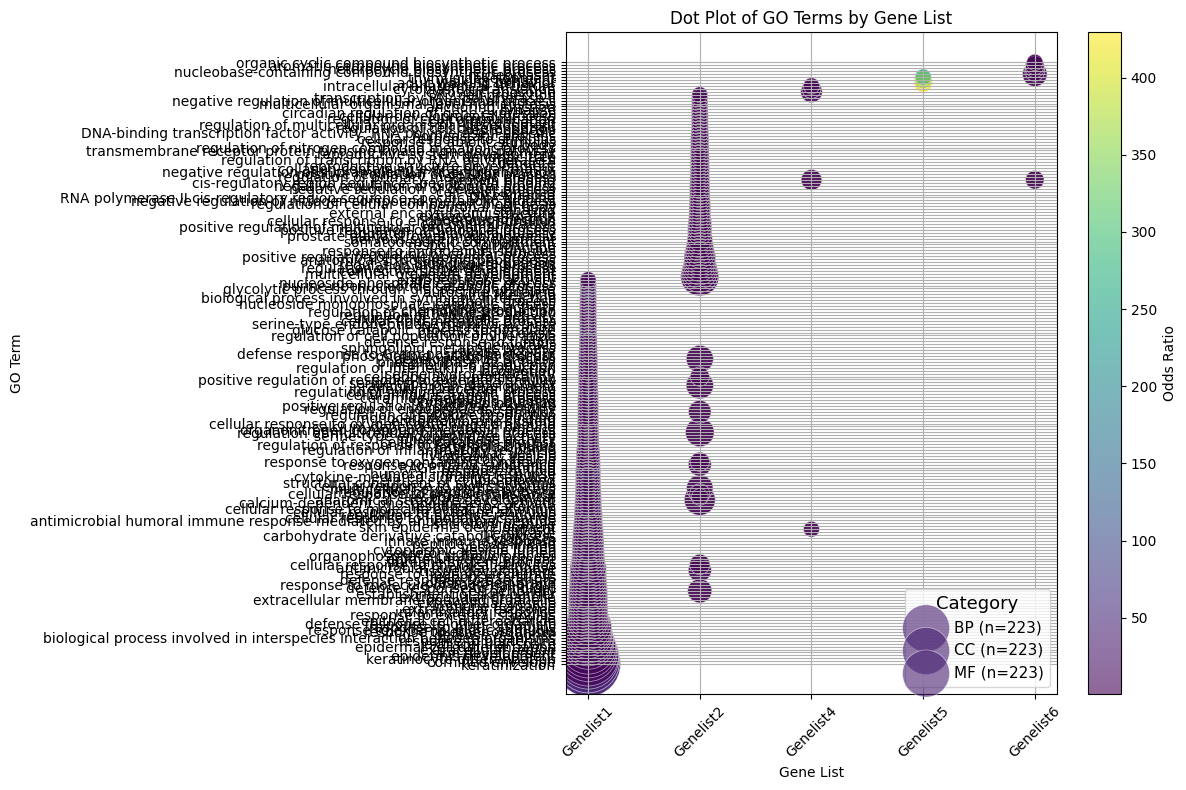

In [ ]:
%pip install matplotlib pandas numpy
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import numpy as np

# Load the combined data
data = pd.read_csv('output_files/combined_dot_plot_data.csv')

# Function to create plots for each gene list
def create_dot_plot_for_gene_list(data, gene_list):
    # Filter data for the specific gene list
    data_gene_list = data[data['gene_list'] == gene_list]

    # Create a normalized color map for p-values
    norm = mcolors.Normalize(vmin=np.log10(data_gene_list['p_value']).min(),
                             vmax=np.log10(data_gene_list['p_value']).max())
    # Choose a colormap
    cmap = plt.cm.viridis

    # Create the scatter plot
    plt.scatter(
        x=data_gene_list['cell_type'],  # Assuming 'cell_type' column is present
        y=data_gene_list['term'],
        s=data_gene_list['odds_ratio'] * 100,  # Dot size represents odds ratio
        c=np.log10(data_gene_list['p_value']),  # Color represents p-value
        cmap=cmap,  # Color map
        norm=norm,  # Normalization of values
        alpha=0.6  # Dot transparency
    )

    # Add a color bar which maps values to colors
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('-log10(p-value)')

    # Add labels and title
    plt.xlabel('Cell Type')
    plt.ylabel('GO Term')
    plt.title(f'Dot Plot of GO Terms by {gene_list}')

    # Rotate x-axis labels if necessary
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)  # Make sure y-axis labels are horizontal

    # Show grid
    plt.grid(True, linestyle='--', linewidth=0.5)

    # Show plot
    plt.tight_layout()
    plt.show()

# Example usage for Genelist1
create_dot_plot_for_gene_list(data, 'Genelist1')

# You can call this function for each of the six gene lists by changing the 'gene_list' argument.


In [31]:
%pip install pygraphviz goatools

import requests
import tempfile
import os
import json
from goatools.obo_parser import GODag
from goatools.godag_plot import plot_gos

def stream_obo_to_temp_file(url):
    """Stream OBO file from URL and temporarily save to disk."""
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        temp_file = tempfile.NamedTemporaryFile(delete=False, suffix='.obo')
        with open(temp_file.name, 'wb') as f_out:
            for chunk in response.iter_content(chunk_size=128):
                f_out.write(chunk)
        return temp_file.name
    else:
        print(f"Failed to download OBO file: {response.status_code}")
        return None

# URL to the Gene Ontology OBO file
obo_url = 'http://purl.obolibrary.org/obo/go/go-basic.obo'

# Stream OBO file and temporarily save to disk
temp_obo_path = stream_obo_to_temp_file(obo_url)

def generate_dag_plots(json_file, temp_obo_path):
    if temp_obo_path:
        print(f"OBO file temporarily saved to {temp_obo_path}")
        go_dag = GODag(temp_obo_path)
        print(f"GO DAG loaded with {len(go_dag)} terms.")

        # Load significant GO IDs from the JSON result file
        with open(json_file) as f:
            data = json.load(f)
            significant_go_ids = {entry['native'] for entry in data if entry['significant']}

        # Filter and sort GO IDs by relevance and select the top result
        plot_go_ids = {go_id for go_id in significant_go_ids if go_id in go_dag}
        sorted_go_ids = sorted(plot_go_ids, key=lambda x: (go_dag[x].level, go_dag[x].depth), reverse=True)[:2]

        # Plotting the GO DAG
        output_folder = 'tcga/nosmoking3_go:bp_ora_dags'
        os.makedirs(output_folder, exist_ok=True)
        file_name = os.path.splitext(os.path.basename(json_file))[0]
        output_file = f"{output_folder}/dag_plot_{file_name}.png"
        title = f""
        
        plot_gos(output_file, sorted_go_ids, go_dag, title=title, mark_alt_id=True, parentcnt=True, childcnt=True)
        print(f"Top 2 GO DAG plot generated at {output_file}")


# List of JSON files to process
json_files = [
    'tcga/nosmoking3_go_ora/Age_down_go:bp.json',
    'tcga/nosmoking3_go_ora/Age_up_go:bp.json',
    'tcga/nosmoking3_go_ora/TissueXSex_down_go:bp.json',
    'tcga/nosmoking3_go_ora/TissueXSex_up_go:bp.json',
    'tcga/nosmoking3_go_ora/TumorVsNormal_down_go:bp.json',
    'tcga/nosmoking3_go_ora/TumorVsNormal_up_go:bp.json'
]

for json_file in json_files:
    generate_dag_plots(json_file, temp_obo_path)

if temp_obo_path:  # Clean up the temporary file
    os.remove(temp_obo_path)

Note: you may need to restart the kernel to use updated packages.
OBO file temporarily saved to /tmp/tmpiuovuudv.obo
/tmp/tmpiuovuudv.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
GO DAG loaded with 45667 terms.
    2 usr  19 GOs  WROTE: tcga/nosmoking3_go:bp_ora_dags/dag_plot_Age_down_go:bp.png
Top 2 GO DAG plot generated at tcga/nosmoking3_go:bp_ora_dags/dag_plot_Age_down_go:bp.png
OBO file temporarily saved to /tmp/tmpiuovuudv.obo
/tmp/tmpiuovuudv.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
GO DAG loaded with 45667 terms.
    2 usr  48 GOs  WROTE: tcga/nosmoking3_go:bp_ora_dags/dag_plot_Age_up_go:bp.png
Top 2 GO DAG plot generated at tcga/nosmoking3_go:bp_ora_dags/dag_plot_Age_up_go:bp.png
OBO file temporarily saved to /tmp/tmpiuovuudv.obo
/tmp/tmpiuovuudv.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
GO DAG loaded with 45667 terms.
    1 usr   3 GOs  WROTE: tcga/nosmoking3_go:bp_ora_dags/dag_plot_TissueXSex_down_go:bp.png
Top 2 GO DAG plot generated at tcga/nosmoking3_go:bp_ora_dags/dag_p

In [25]:
%pip install pygraphviz goatools

import requests
import tempfile
import os
import json
from goatools.obo_parser import GODag
from goatools.godag_plot import plot_gos

def stream_obo_to_temp_file(url):
    """Stream OBO file from URL and temporarily save to disk."""
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        temp_file = tempfile.NamedTemporaryFile(delete=False, suffix='.obo')
        with open(temp_file.name, 'wb') as f_out:
            for chunk in response.iter_content(chunk_size=128):
                f_out.write(chunk)
        return temp_file.name
    else:
        print(f"Failed to download OBO file: {response.status_code}")
        return None

# URL to the Gene Ontology OBO file
obo_url = 'http://purl.obolibrary.org/obo/go/go-basic.obo'

# Stream OBO file and temporarily save to disk
temp_obo_path = stream_obo_to_temp_file(obo_url)

def generate_dag_plots(json_file, temp_obo_path):
    if temp_obo_path:
        print(f"OBO file temporarily saved to {temp_obo_path}")
        go_dag = GODag(temp_obo_path)
        print(f"GO DAG loaded with {len(go_dag)} terms.")

        # Load significant GO IDs from the JSON result file
        with open(json_file) as f:
            data = json.load(f)
            significant_go_ids = {entry['native'] for entry in data if entry['significant']}

        # Filter and sort GO IDs by relevance and select the top 3
        plot_go_ids = {go_id for go_id in significant_go_ids if go_id in go_dag}
        sorted_go_ids = sorted(plot_go_ids, key=lambda x: (go_dag[x].level, go_dag[x].depth), reverse=True)[:5]

        # Plotting the GO DAG
        output_folder = 'tcga/nosmoking3_go:mf_ora_dags'
        file_name = os.path.splitext(os.path.basename(json_file))[0]
        output_file = f"{output_folder}/dag_plot_{file_name}.png"
        os.makedirs(output_folder, exist_ok=True)
        title = f""
        plot_gos(output_file, sorted_go_ids, go_dag,
                 title=title,
                 mark_alt_id=True, parentcnt=True, childcnt=True)
        print(f"Top 5 GO DAG plot for {os.path.basename(json_file)} generated at {output_file}")

# List of JSON files to process
json_files = [
    'tcga/nosmoking3_go_ora/Age_down_go:mf.json',
    'tcga/nosmoking3_go_ora/Age_up_go:mf.json',
    'tcga/nosmoking3_go_ora/MaleVsFemale_up_go:mf.json',
    'tcga/nosmoking3_go_ora/TissueXSex_up_go:mf.json',
    'tcga/nosmoking3_go_ora/TumorVsNormal_down_go:mf.json',
    'tcga/nosmoking3_go_ora/TumorVsNormal_up_go:mf.json'
]

for json_file in json_files:
    generate_dag_plots(json_file, temp_obo_path)

if temp_obo_path:  # Clean up the temporary file
    os.remove(temp_obo_path)

Note: you may need to restart the kernel to use updated packages.
OBO file temporarily saved to /tmp/tmp0v6gpi5g.obo
/tmp/tmp0v6gpi5g.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
GO DAG loaded with 45667 terms.
    5 usr  16 GOs  WROTE: tcga/nosmoking3_go:mf_ora_dags/dag_plot_Age_down_go:mf.png
Top 5 GO DAG plot for Age_down_go:mf.json generated at tcga/nosmoking3_go:mf_ora_dags/dag_plot_Age_down_go:mf.png
OBO file temporarily saved to /tmp/tmp0v6gpi5g.obo
/tmp/tmp0v6gpi5g.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
GO DAG loaded with 45667 terms.
    5 usr  22 GOs  WROTE: tcga/nosmoking3_go:mf_ora_dags/dag_plot_Age_up_go:mf.png
Top 5 GO DAG plot for Age_up_go:mf.json generated at tcga/nosmoking3_go:mf_ora_dags/dag_plot_Age_up_go:mf.png
OBO file temporarily saved to /tmp/tmp0v6gpi5g.obo
/tmp/tmp0v6gpi5g.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
GO DAG loaded with 45667 terms.
    5 usr  12 GOs  WROTE: tcga/nosmoking3_go:mf_ora_dags/dag_plot_MaleVsFemale_up_go:mf.png
Top 5 GO DAG plot for

In [26]:
%pip install pygraphviz goatools

import requests
import tempfile
import os
import json
from goatools.obo_parser import GODag
from goatools.godag_plot import plot_gos

def stream_obo_to_temp_file(url):
    """Stream OBO file from URL and temporarily save to disk."""
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        temp_file = tempfile.NamedTemporaryFile(delete=False, suffix='.obo')
        with open(temp_file.name, 'wb') as f_out:
            for chunk in response.iter_content(chunk_size=128):
                f_out.write(chunk)
        return temp_file.name
    else:
        print(f"Failed to download OBO file: {response.status_code}")
        return None

# URL to the Gene Ontology OBO file
obo_url = 'http://purl.obolibrary.org/obo/go/go-basic.obo'

# Stream OBO file and temporarily save to disk
temp_obo_path = stream_obo_to_temp_file(obo_url)

def generate_dag_plots(json_file, temp_obo_path):
    if temp_obo_path:
        print(f"OBO file temporarily saved to {temp_obo_path}")
        go_dag = GODag(temp_obo_path)
        print(f"GO DAG loaded with {len(go_dag)} terms.")

        # Load significant GO IDs from the JSON result file
        with open(json_file) as f:
            data = json.load(f)
            significant_go_ids = {entry['native'] for entry in data if entry['significant']}

        # Filter and sort GO IDs by relevance and select the top 3
        plot_go_ids = {go_id for go_id in significant_go_ids if go_id in go_dag}
        sorted_go_ids = sorted(plot_go_ids, key=lambda x: (go_dag[x].level, go_dag[x].depth), reverse=True)[:5]

        # Plotting the GO DAG
        output_folder = 'tcga/nosmoking3_go:cc_ora_dags'
        file_name = os.path.splitext(os.path.basename(json_file))[0]
        output_file = f"{output_folder}/dag_plot_{file_name}.png"
        os.makedirs(output_folder, exist_ok=True)
        title = f""
        plot_gos(output_file, sorted_go_ids, go_dag,
                 title=title,
                 mark_alt_id=True, parentcnt=True, childcnt=True)
        print(f"Top 5 GO DAG plot for {os.path.basename(json_file)} generated at {output_file}")

# List of JSON files to process
json_files = [
    'tcga/nosmoking3_go_ora/Age_down_go:cc.json',
    'tcga/nosmoking3_go_ora/Age_up_go:cc.json',
    'tcga/nosmoking3_go_ora/TissueXSex_down_go:cc.json',
    'tcga/nosmoking3_go_ora/TissueXSex_up_go:cc.json',
    'tcga/nosmoking3_go_ora/TumorVsNormal_down_go:cc.json',
    'tcga/nosmoking3_go_ora/TumorVsNormal_up_go:cc.json'
]

for json_file in json_files:
    generate_dag_plots(json_file, temp_obo_path)

if temp_obo_path:  # Clean up the temporary file
    os.remove(temp_obo_path)

Note: you may need to restart the kernel to use updated packages.
OBO file temporarily saved to /tmp/tmpuhp6jtsf.obo
/tmp/tmpuhp6jtsf.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
GO DAG loaded with 45667 terms.
    5 usr  20 GOs  WROTE: tcga/nosmoking3_go:cc_ora_dags/dag_plot_Age_down_go:cc.png
Top 5 GO DAG plot for Age_down_go:cc.json generated at tcga/nosmoking3_go:cc_ora_dags/dag_plot_Age_down_go:cc.png
OBO file temporarily saved to /tmp/tmpuhp6jtsf.obo
/tmp/tmpuhp6jtsf.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
GO DAG loaded with 45667 terms.
    5 usr  23 GOs  WROTE: tcga/nosmoking3_go:cc_ora_dags/dag_plot_Age_up_go:cc.png
Top 5 GO DAG plot for Age_up_go:cc.json generated at tcga/nosmoking3_go:cc_ora_dags/dag_plot_Age_up_go:cc.png
OBO file temporarily saved to /tmp/tmpuhp6jtsf.obo
/tmp/tmpuhp6jtsf.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
GO DAG loaded with 45667 terms.
    5 usr  20 GOs  WROTE: tcga/nosmoking3_go:cc_ora_dags/dag_plot_TissueXSex_down_go:cc.png
Top 5 GO DAG plot for

In [4]:
# Clean up: Remove the temporary OBO file after use
os.unlink(temp_obo_path)
print(f"Temporary OBO file {temp_obo_path} removed.")


Temporary OBO file /tmp/tmpw6ymiipm.obo removed.
